# 🏡 Aprendizado não supervisionado

## Descrição

Para atender as necessidades de um leque de decisões financeiras, o Banco Santander oferece sugestões de produtos de interesse aos seus clientes por meio de recomendações personalizadas de produtos.

Atualmente, um pequeno número de clientes recebe muitas recomendações, enquanto uma quantidade maior de clientes raramente recebe as recomendações. Isso resulta em uma experiência desigual para os clientes.

Existem diferentes abordagens e análises que podem ser feitas para entender melhor as necessidades dos clientes. Com um sistema de recomendação mais eficaz, o Santander pode atender melhor às necessidades individuais de todos os clientes e garantir sua satisfação.

Para essa atividade, focaremos na identificação de clientes com comportamentos e características semelhantes utilizando um conjunto de dados disponibilizado na competição Santander Product Recommendation (https://www.kaggle.com/c/santander-product-recommendation/). Note que os requisitos dessa atividade são diferentes dos enunciados na competição original.

Nessa atividade, é fornecida 1 ano e 5 meses de dados de comportamento dos clientes do banco Santander. Os dados começam em 28/01/2015 e têm registros mensais de produtos que um cliente possui, como "cartão de crédito", "conta poupança", etc. A última informação é referente a data de 28/05/2016. Esses produtos são as colunas nomeadas: ind_(xyz)_ult1, que são as colunas 25-48 nos dados de treinamento.

O conjunto de dados utilizado não inclui nenhum cliente real do Santander Espanha e, portanto, não é representativo da base de clientes da Espanha. A tarefa é entender os diferentes perfis de clientes e de produtos que existem na base de dados.

Apenas o conjunto de treinamento será utilizado nesta atividade. Considere a experiência adquirida na Atividade 1 e os outros conteúdos passados na disciplina para:

- Explorar as variáveis disponíveis no conjunto de dados, usando ferramentas apresentadas em aula;
- Pré-processar adequadamente os dados.
- Realizar o agrupamento dos clientes, usando os algoritmos KMeans e DBSCAN;
- Validar os agrupamentos gerados como resultado da tarefa utilizando medidas internas dos dados disponíveis;
- Descrever de forma manual ou automatizada ao menos 2 agrupamentos de clientes.

Isto é, após segmentar os clientes em diferentes perfis, tente analisar e descrever (textualmente) o comportamento de (pelo menos) 2 grupos distintos.

Exemplo: selecione os clientes que pertencem a algum cluster encontrado e busque entender o comportamento das variáveis para este cluster. Como elas diferem do comportamento geral ou do comportamento em outros clusters?

## Instruções para acesso aos dados

Os dados estão disponíveis na plataforma Kaggle em https://www.kaggle.com/c/santander-product-recommendation/data

Para acessá-los, será necessário criar uma conta na plataforma. Na página da competição também será necessário concordar os termos dispostos.

Nesta atividade, é suficiente utilizar o arquivo train_ver2.csv.zip. O arquivo pode ser baixado diretamente pela interface web. Uma alternativa é utilizar a linha de comando do Kaggle, útil por exemplo caso você vá utilizar o Google Colab. Para isso:

1. Obtenha o arquivo kaggle.json seguindo as instruções em https://github.com/Kaggle/kaggle-api#api-credentials.
2. Faça o upload no arquivo no Colab:
3. Utilize o notebook a seguir como base: https://colab.research.google.com/drive/1UiZ1EXeJDkGJaCFFd4untMQ5dqywL8hU?usp=sharing

Para simplificar, iremos utilizar apenas um subconjunto dos dados, referente ao mês 05/2016. O notebook de exemplo também mostra como gerar esse subconjunto de dados.

## Orientações gerais:

- Códigos públicos podem ser utilizados como inspiração para o desenvolvimento da atividade, mas todo material gerado deve ser de autoria do aluno ou possuir referência.
- A qualidade dos resultados finais em si é menos importante do que a coerência durante as análises e as abordagens exploradas.
- Não é necessário fazer nenhum tipo de predição.
- A tarefa deve ser entregue no formato .ipynb, que deve conter documentação detalhada de todas as etapas.
- Entregar (no ava-iti – tarefa de arquivo único) com o arquivo no formato especificado acima.


# ⚙️ Setup

## Dependências

In [1]:
# Instalação das dependências
%pip install rich
%pip install requests

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Bibliotecas de uso geral
from __future__ import annotations
from typing import Callable

from itertools import cycle

from dataclasses import dataclass
from dataclasses import field

from datetime import datetime
from pprint import pprint

import requests
import tarfile
import pickle
import os
import multiprocessing
import string

In [3]:
# Biblioteca para formatação do console
from rich.console import Console
from rich.table import Table
from rich.progress import track
console = Console()

In [4]:
# Biblioteca de manipulação de dados
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 36)

In [5]:
# Biblitecas de aprendizado de máquina
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans

from sklearn.metrics import silhouette_score
from sklearn.manifold import Isomap 
from sklearn import metrics

In [6]:
# Biblioteca de visualização do KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [7]:
# Bibliotecas para gráficos
import matplotlib.pyplot as plt
import matplotlib as mpl

# Corrige o modo de visualização das imagens
%config InlineBackend.figure_format = 'svg'

# Formatação das figuras
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['savefig.dpi'] = 600

# Formatação dos textos
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 9
mpl.rcParams['legend.fontsize'] = 'medium'

mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize'] = 'x-large'

mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

mpl.rcParams['grid.color'] = '#E0E0E0'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.8
mpl.rcParams['grid.alpha'] = 0.8

# Redefine a lista padrão de cores
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#293462', '#0083af','#1CD6CE', '#82e484',
                                                    '#FEDB39', '#fe8132', '#D61C4E', '#862e77',]) 

## Classes Auxiliares

In [8]:
class Plot:
    """Classe wrapper para padronizar as funções mais comuns do matplotlib.
    """
    
    @staticmethod
    def subplots(nrows=1, ncols=1):
        return plt.subplots(nrows, ncols, figsize=(min(6.0 * ncols, 12.0), min(12.0 / ncols, 4.0) * nrows), layout='tight')

    @staticmethod
    def mosaic(grid):
        ncols = len(grid[0])
        nrows = len(grid)
        return plt.subplot_mosaic(grid, figsize=(min(6.0 * ncols, 12.0), min(12.0 / ncols, 4.0) * nrows), layout='constrained')
    
    @staticmethod
    def show(nrows=1, ncols=1):
        plt.tight_layout(w_pad=3, h_pad=3)
        
    @staticmethod
    def colors():
        return cycle([f'C{i}' for i in range(8)])

In [9]:
class DataAnalysis:
    
    @staticmethod
    def print_summary(df: pd.DataFrame, filtro: str = None):
        """Imprime um resumo com os tipos de dados e amostra dos valores categóricos.
        """
        dtypes = {
            'int': ['uint8', 'int8', 'int16', 'int32', 'int64'],
            'float': ['float64'],
            'bool': ['bool'],
            'category': ['category'],
        }

        for tipo, dtype in dtypes.items():
            if filtro and tipo != filtro: 
                continue
                
            rows = []
            for dt in dtype:
                serie = pd.Series({col: df[col] for col in df.select_dtypes(include=[dt])}, dtype='object')
                for k, v in serie.items():
                    unicos = v.nunique()
                    nulos_abs = len(v[v.isna()])
                    nulos_per = len(v[v.isna()]) / len(df) * 100

                    if tipo in ('int', 'float'):
                        rows.append((dt, str(k), f'({v.min()}, {v.max()})', f'{unicos}', f'{nulos_abs}', f'{nulos_per:.2f}%'))
                    elif tipo == 'bool':
                        rows.append((dt, str(k), f'{v.unique()}', f'{unicos}', f'{nulos_abs}', f'{nulos_per:.2f}%'))
                    else:
                        rows.append((dt, str(k), f'{v.unique().to_list()[:8]}', f'{unicos}', f'{nulos_abs}', f'{nulos_per:.2f}%'))


            if not rows:
                continue

            table = Table(show_header=True, header_style="bold", title=f'Tipo: {tipo}') 
            table.add_column("Tipo", style="dim", width=12)
            table.add_column("Atributo", style="green", width=24)
            table.add_column("Domínio", no_wrap=True, width=60)
            table.add_column("Únicos",  style='blue', width=12)
            table.add_column("Nulos",  style='red', width=12)
            table.add_column("Nulos%",  style='yellow', width=12)

            for r in rows:
                table.add_row(*r)

            console.print(table)  

# 🗄 Conjunto de dados

## Descrição

Descrição de todos os atributos do conjunto de dados.

| **Atributo**               | **Descrição** |
|:---------------------------|:--------------|
| **fecha_dato**             | The table is partitioned for this column |
| **ncodpers**               | Customer code |
| **ind_empleado**           | Employee index                       A active, B ex employed, F filial, N not employee, P pasive |
| **pais_residencia**        | Customer's Country residence |
| **sexo**                   | Customer's sex |
| **age**                    | Age |
| **fecha_alta**             | The date in which the customer became as the first holder of a contract in the bank |
| **ind_nuevo**              | New customer Index. 1 if the customer registered in the last 6 months. |
| **antiguedad**             | Customer seniority (in months) |
| **indrel**                 | 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month) |
| **ult_fec_cli_1t**         | Last date as primary customer (if he isn't at the end of the month) |
| **indrel_1mes**            | Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner) |
| **tiprel_1mes**            | Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential) |
| **indresi**                | Residence index (S (Yes) or N (No) if the residence country is the same than the bank country) |
| **indext**                 | Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country) |
| **conyuemp**               | Spouse index. 1 if the customer is spouse of an employee |
| **canal_entrada**          | channel used by the customer to join |
| **indfall**                | Deceased index. N/S |
| **tipodom**                | Addres type. 1, primary address |
| **cod_prov**               | Province code (customer's address) |
| **nomprov**                | Province name |
| **ind_actividad_cliente**  | Activity index (1, active customer; 0, inactive customer) |
| **renta**                  | Gross income of the household |
| **segmento**               | segmentation 01 - VIP, 02 - Individuals 03 - college graduated |
| **ind_ahor_fin_ult1**      | Saving Account |
| **ind_aval_fin_ult1**      | Guarantees |
| **ind_cco_fin_ult1**       | Current Accounts |
| **ind_cder_fin_ult1**      | Derivada Account |
| **ind_cno_fin_ult1**       | Payroll Account |
| **ind_ctju_fin_ult1**      | Junior Account |
| **ind_ctma_fin_ult1**      | Más particular Account |
| **ind_ctop_fin_ult1**      | particular Account |
| **ind_ctpp_fin_ult1**      | particular Plus Account |
| **ind_deco_fin_ult1**      | Short-term deposits |
| **ind_deme_fin_ult1**      | Medium-term deposits |
| **ind_dela_fin_ult1**      | Long-term deposits |
| **ind_ecue_fin_ult1**      | e-account |
| **ind_fond_fin_ult1**      | Funds |
| **ind_hip_fin_ult1**       | Mortgage |
| **ind_plan_fin_ult1**      | Pensions |
| **ind_pres_fin_ult1**      | Loans |
| **ind_reca_fin_ult1**      | Taxes |
| **ind_tjcr_fin_ult1**      | Credit Card |
| **ind_valo_fin_ult1**      | Securities |
| **ind_viv_fin_ult1**       | Home Account |
| **ind_nomina_ult1**        | Payroll |
| **ind_nom_pens_ult1**      | Pensions |
| **ind_recibo_ult1**        | Direct Debit |

O conjunto de dados é muito grande e não está otimizado. Por isso, será feita uma análise inicial de todos os atributos e o tipo de dados mais adequado em cada um dos casos.

In [10]:
# Caminho do dataset
URL='https://github.com/chaua/mba-machine-learning/blob/main/iml2/atividade2/data_05-2016.tgz?raw=true'

response = requests.get(URL, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path='/tmp')

In [11]:
# Carrega todo o dataset original
#df = pd.read_csv('./data_05-2016.csv', low_memory=False)
#df.info(memory_usage="deep")

#> memory usage: 1000.8 MB

In [12]:
# Carrega uma parte do dataset correspondente ao período 05-2016
df = pd.read_csv('/tmp/data_05-2016.csv', nrows=1000)
df.shape

(1000, 48)

In [13]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fecha_dato             1000 non-null   object 
 1   ncodpers               1000 non-null   int64  
 2   ind_empleado           1000 non-null   object 
 3   pais_residencia        1000 non-null   object 
 4   sexo                   1000 non-null   object 
 5   age                    1000 non-null   int64  
 6   fecha_alta             1000 non-null   object 
 7   ind_nuevo              1000 non-null   float64
 8   antiguedad             1000 non-null   int64  
 9   indrel                 1000 non-null   float64
 10  ult_fec_cli_1t         0 non-null      float64
 11  indrel_1mes            1000 non-null   object 
 12  tiprel_1mes            1000 non-null   object 
 13  indresi                1000 non-null   object 
 14  indext                 1000 non-null   object 
 15  conyu

In [14]:
df.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2016-05-28,657640,N,ES,H,68,2006-11-17,0.0,114,1.0,NaN,1,I,S,N,NaN,KAQ,N,1.0,28.0,MADRID,0.0,147347.97,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2016-05-28,657788,N,ES,H,42,2006-11-18,0.0,114,1.0,NaN,1,A,S,N,NaN,KBF,N,1.0,28.0,MADRID,1.0,132559.35,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2016-05-28,657795,N,ES,V,44,2006-11-18,0.0,114,1.0,NaN,1,A,S,N,NaN,KAP,N,1.0,26.0,"RIOJA, LA",1.0,81399.57,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2016-05-28,657790,N,ES,V,42,2006-11-18,0.0,114,1.0,NaN,1,A,S,N,NaN,KBF,N,1.0,48.0,BIZKAIA,1.0,NaN,02 - PARTICULARES,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1.0,1.0,1
4,2016-05-28,657794,N,ES,H,49,2006-11-18,0.0,114,1.0,NaN,1,A,S,N,NaN,KAT,N,1.0,8.0,BARCELONA,1.0,102189.00,01 - TOP,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0


Mapeamento dos tipos de dados de cada um dos atributos:

```
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fecha_dato             1000 non-null   object  --> Valor constante para o domínio do problema (EXCLUIR) 
 1   ncodpers               1000 non-null   int32   --> Identificador do cliente
 2   ind_empleado           1000 non-null   object  --> category
 3   pais_residencia        1000 non-null   object  --> category
 4   sexo                   1000 non-null   object  --> category
 5   age                    1000 non-null   int64   --> int16
 6   fecha_alta             1000 non-null   object  --> datetime64
 7   ind_nuevo              1000 non-null   float64 --> bool
 8   antiguedad             1000 non-null   int64   --> int32
 9   indrel                 1000 non-null   float64 --> int8
 10  ult_fec_cli_1t         0 non-null      float64 --> datetime64 (?)
 11  indrel_1mes            1000 non-null   object  --> int8
 12  tiprel_1mes            1000 non-null   object  --> category
 13  indresi                1000 non-null   object  --> category
 14  indext                 1000 non-null   object  --> category
 15  conyuemp               0 non-null      float64 --> bool
 16  canal_entrada          997 non-null    object  --> category
 17  indfall                1000 non-null   object  --> category 
 18  tipodom                1000 non-null   float64 --> bool
 19  cod_prov               990 non-null    float64 --> int8
 20  nomprov                990 non-null    object  --> str
 21  ind_actividad_cliente  1000 non-null   float64 --> bool
 22  renta                  831 non-null    float64 --> float64
 23  segmento               997 non-null    object  --> category
 24  ind_ahor_fin_ult1      1000 non-null   int64   --> bool
 25  ind_aval_fin_ult1      1000 non-null   int64   --> bool
 26  ind_cco_fin_ult1       1000 non-null   int64   --> bool
 27  ind_cder_fin_ult1      1000 non-null   int64   --> bool
 28  ind_cno_fin_ult1       1000 non-null   int64   --> bool
 29  ind_ctju_fin_ult1      1000 non-null   int64   --> bool
 30  ind_ctma_fin_ult1      1000 non-null   int64   --> bool
 31  ind_ctop_fin_ult1      1000 non-null   int64   --> bool
 32  ind_ctpp_fin_ult1      1000 non-null   int64   --> bool
 33  ind_deco_fin_ult1      1000 non-null   int64   --> bool
 34  ind_deme_fin_ult1      1000 non-null   int64   --> bool
 35  ind_dela_fin_ult1      1000 non-null   int64   --> bool
 36  ind_ecue_fin_ult1      1000 non-null   int64   --> bool
 37  ind_fond_fin_ult1      1000 non-null   int64   --> bool
 38  ind_hip_fin_ult1       1000 non-null   int64   --> bool
 39  ind_plan_fin_ult1      1000 non-null   int64   --> bool
 40  ind_pres_fin_ult1      1000 non-null   int64   --> bool
 41  ind_reca_fin_ult1      1000 non-null   int64   --> bool
 42  ind_tjcr_fin_ult1      1000 non-null   int64   --> bool
 43  ind_valo_fin_ult1      1000 non-null   int64   --> bool
 44  ind_viv_fin_ult1       1000 non-null   int64   --> bool
 45  ind_nomina_ult1        1000 non-null   float64 --> bool
 46  ind_nom_pens_ult1      1000 non-null   float64 --> bool
 47  ind_recibo_ult1        1000 non-null   int64   --> bool
```

In [15]:
# Nova definição dos tipos de dados de todos os atributos
dtypes = {
    'ncodpers'              : 'int32',   
    'ind_empleado'          : 'category',
    'pais_residencia'       : 'category',
    'sexo'                  : 'category',
    'age'                   : 'int16',
    'ind_nuevo'             : 'bool',
    'antiguedad'            : 'int32',
    'indrel'                : 'int8',
    'indrel_1mes'           : 'category',
    'tiprel_1mes'           : 'category',
    'indresi'               : 'category',
    'indext'                : 'category',
    'canal_entrada'         : 'category',
    'indfall'               : 'category',
    'tipodom'               : 'bool',
    'nomprov'               : 'category',
    'ind_actividad_cliente' : 'bool',
    'renta'                 : 'float64',
    'segmento'              : 'category',
    'ind_ahor_fin_ult1'     : 'bool',
    'ind_aval_fin_ult1'     : 'bool',
    'ind_cco_fin_ult1'      : 'bool',
    'ind_cder_fin_ult1'     : 'bool',
    'ind_cno_fin_ult1'      : 'bool',
    'ind_ctju_fin_ult1'     : 'bool',
    'ind_ctma_fin_ult1'     : 'bool',
    'ind_ctop_fin_ult1'     : 'bool',
    'ind_ctpp_fin_ult1'     : 'bool',
    'ind_deco_fin_ult1'     : 'bool',
    'ind_deme_fin_ult1'     : 'bool',
    'ind_dela_fin_ult1'     : 'bool',
    'ind_ecue_fin_ult1'     : 'bool',
    'ind_fond_fin_ult1'     : 'bool',
    'ind_hip_fin_ult1'      : 'bool',
    'ind_plan_fin_ult1'     : 'bool',
    'ind_pres_fin_ult1'     : 'bool',
    'ind_reca_fin_ult1'     : 'bool',
    'ind_tjcr_fin_ult1'     : 'bool',
    'ind_valo_fin_ult1'     : 'bool',
    'ind_viv_fin_ult1'      : 'bool',
    'ind_nomina_ult1'       : 'bool',
    'ind_nom_pens_ult1'     : 'bool',
    'ind_recibo_ult1'       : 'bool',
}

# Funções de conversão de tipos
# - Alguns atributos possuem tipos de dados misturados
# - Por isso, precisamos tratar a conversão dos dados manualmente
def to_bool(val):
    return bool(val)

def to_int(val):
    if isinstance(val, str) and not val:
        return 0
    return int(float(val))

converters = {
    'conyuemp'           : to_bool,
    'cod_prov'           : to_int,
}

In [16]:
# Carrega uma parte do dataset correspondente ao período 05-2016
df = pd.read_csv('/tmp/data_05-2016.csv', 
                 dtype=dtypes, 
                 converters=converters, 
                 usecols=list(dtypes.keys()) + list(converters.keys()))
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931453 entries, 0 to 931452
Columns: 45 entries, ncodpers to ind_recibo_ult1
dtypes: bool(28), category(11), float64(1), int16(1), int32(2), int64(1), int8(1)
memory usage: 59.5 MB


ℹ️ Com a otimização dos tipos dos dados, o tamanho do DataFrame reduziu de 1000.8 MB para 59.5 MB

## Análise - atributos inteiros

In [17]:
# Verifica o domínio de todos os atributos do conjunto de dados
DataAnalysis.print_summary(df, 'int')

                                                     Tipo: int                                                     
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Tipo   ┃ Atributo           ┃ Domínio                                                ┃ Únicos ┃ Nulos  ┃ Nulos% ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ int8   │ indrel             │ (1, 99)                                                │ 2      │ 0      │ 0.00%  │
│ int16  │ age                │ (2, 164)                                               │ 118    │ 0      │ 0.00%  │
│ int32  │ ncodpers           │ (15889, 1553689)                                       │ 931453 │ 0      │ 0.00%  │
│ int32  │ antiguedad         │ (-999999, 256)                                         │ 258    │ 0      │ 0.00%  │
│ int64  │ cod_prov           │ (0, 52)                                                │ 53     │ 0      │ 0.00%  │
└────────┴────────────────────┴────────────────────────────────────────────────────────┴────────┴────────┴────────┘

### `indrel`

In [18]:
df.indrel.value_counts(normalize=True).mul(100).round(1)

1     99.8
99     0.2
Name: indrel, dtype: float64

**Considerações**

- O atributo é categórico e está desbalanceado.
- Pode ser removido

### `age`

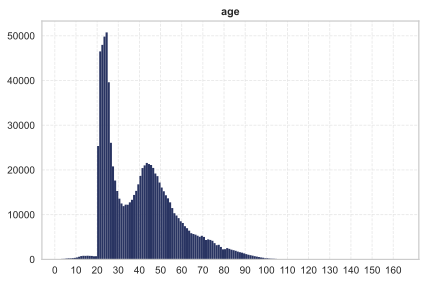

In [19]:
fig, ax = Plot.subplots()

ax.set_xticks(np.arange(0, 170, 10))
ax.set_title('age')

df.age.hist(ax=ax, bins=162)

Plot.show()

In [20]:
menores_18 = len(df.query('age < 18'))
maiores_90 = len(df.query('age > 90'))

console.print(f'Menores de 18...: {menores_18 / len(df) * 100:.2f}%')
console.print(f'Maiores de 90...: {maiores_90 / len(df) * 100:.2f}%')

Menores de 18...: 0.79%

Maiores de 90...: 0.75%

**Considerações**

- Indivíduos com menos de 18 anos e acima de 90 anos correspondem a 0,79% e 0,75% dos registros da base.
- Por não serem economicamente ativos, podem ser excluídos para evitar que atuem como outliers.

### `ncodpers`

In [21]:
len(df) == len(df.ncodpers)

True

**Considerações**

- Identificador único dos clientes. Pode ser utilizado como índice.

### `antiguedad`

In [22]:
df.antiguedad.value_counts(normalize=True).mul(100).sort_index()

-999999    0.000322
 0         0.502333
 1         0.447902
 2         0.493852
 3         0.665627
             ...   
 252       0.027162
 253       0.016211
 254       0.009126
 255       0.008267
 256       0.010951
Name: antiguedad, Length: 258, dtype: float64

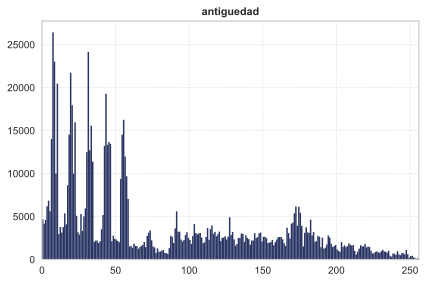

In [23]:
fig, ax = Plot.subplots()

ax.set_xticks(np.arange(0, 256, 50))
ax.set_xlim(0, 256)
ax.set_title('antiguedad')

df.query('antiguedad >= 0').antiguedad.hist(ax=ax, bins=256)

Plot.show()

**Considerações**

- Indicador -999999 indica dados faltantes. Como a amostragem corresponde a 0,0003% da base, esses registros podem ser removidos.

### `cod_prov`

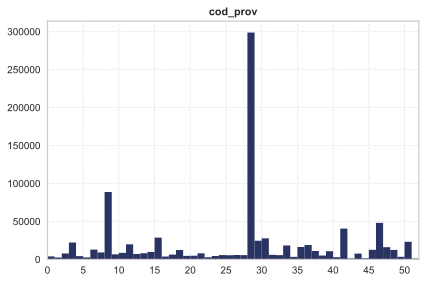

In [24]:
fig, ax = Plot.subplots()

ax.set_xticks(np.arange(0, 52, 5))
ax.set_xlim(0, 52)

ax.set_title('cod_prov')

df.cod_prov.hist(ax=ax, bins=52)

Plot.show()

In [25]:
df.cod_prov.value_counts(normalize=True).mul(100)

28    32.083315
8      9.528554
46     5.164297
41     4.356742
15     3.088830
        ...    
1      0.278812
44     0.165118
42     0.135380
52     0.068817
51     0.055075
Name: cod_prov, Length: 53, dtype: float64

**Considerações**

- A cidade com ID 28 é a que possui maior concentração das amostras: 32% da base
- O código da província está relacionado com o nome da província. Umas das colunas pode ser ignorada

## Análise - atributos reais

In [26]:
# Verifica o domínio de todos os atributos do conjunto de dados
DataAnalysis.print_summary(df, 'float')

                                                    Tipo: float                                                    
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Tipo   ┃ Atributo           ┃ Domínio                                                ┃ Únicos ┃ Nulos  ┃ Nulos% ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ float… │ renta              │ (1202.73, 28894395.51)                                 │ 516843 │ 229018 │ 24.59% │
└────────┴────────────────────┴────────────────────────────────────────────────────────┴────────┴────────┴────────┘

### `renta`

In [27]:
df.renta.describe().apply(lambda x: format(x, 'f'))

count      702435.000000
mean       134089.637098
std        232220.499611
min          1202.730000
25%         68493.795000
50%        101493.450000
75%        155546.355000
max      28894395.510000
Name: renta, dtype: object

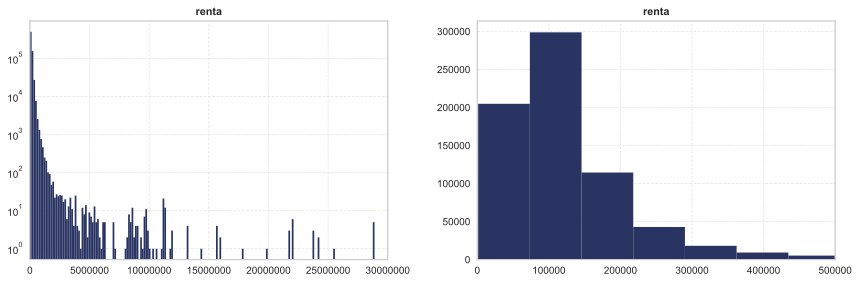

In [28]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

# Todos os clientes
ax1.set_xlim(0, 30_000_000)
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.set_title('renta')

df.renta.hist(ax=ax1, bins=200, log=True)

# Clientes com renda normal
ax2.set_xlim(0, 500_000)
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_title('renta')

df.renta.hist(ax=ax2, bins=400)

Plot.show()

In [29]:
clientes_ricos = len(df.query('renta > 250_000'))
console.print(f'Clientes ricos...: {clientes_ricos / len(df) * 100:.2f}%')

Clientes ricos...: 6.43%

In [30]:
# Verifica quais paises possuem renda 
df.query('renta.notna()').groupby('pais_residencia').agg('renta').median().isna().value_counts()

True     94
False    24
Name: renta, dtype: int64

**Considerações**

- Maior concentração de clientes entre 68k e 156k.
- Os clientes com renda que varia de 250k até 30M correspondem a 6,4% da base.
- Embora sejam valores fora da curva, estes clientes serão considerados no modelo por seram clientes estratégicos para o banco.
- O atributo renda possui valores nulos que correspondem a 25% da base.
    - Os clientes sem renda podem ser ignorados para diminiur o tamanho do dataset
- No total, 94 países possuem o atributo renda faltante. Algumas estratégias:
    - Assumir a renda média para esses países
    - Remover estes registros dos datasets

## Análise - atributos categóricos

In [31]:
# Verifica o domínio de todos os atributos do conjunto de dados
DataAnalysis.print_summary(df, 'category')

                                                  Tipo: category                                                   
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Tipo   ┃ Atributo           ┃ Domínio                                                ┃ Únicos ┃ Nulos  ┃ Nulos% ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ categ… │ ind_empleado       │ ['N', 'A', 'S', 'F', 'B']                              │ 5      │ 0      │ 0.00%  │
│ categ… │ pais_residencia    │ ['ES', 'BO', 'AR', 'IN', 'RO', 'PY', 'US', 'BE']       │ 118    │ 0      │ 0.00%  │
│ categ… │ sexo               │ ['H', 'V', nan]                                        │ 2      │ 5      │ 0.00%  │
│ categ… │ indrel_1mes        │ ['1', '1.0', 'P', '3', '3.0', '2.0', nan, '2']         │ 9      │ 4010   │ 0.43%  │
│ categ… │ tiprel_1mes        │ ['I', 'A', 'R', 'P', nan]                              │ 4      │ 4010   │ 0.43%  │
│ categ… │ indresi            │ ['S', 'N']                                             │ 2      │ 0      │ 0.00%  │
│ categ… │ indext             │ ['N', 'S']                                             │ 2      │ 0      │ 0.00%  │
│ categ… │ canal_entrada      │ ['KAQ', 'KBF', 'KAP', 'KAT', 'KFC', 'KFA', 'KAE', 'KA… │ 162    │ 6699   │ 0.72%  │
│ categ… │ indfall            │ ['N', 'S']                                             │ 2      │ 0      │ 0.00%  │
│ categ… │ nomprov            │ ['MADRID', 'RIOJA, LA', 'BIZKAIA', 'BARCELONA', 'ZARA… │ 52     │ 3992   │ 0.43%  │
│ categ… │ segmento           │ ['02 - PARTICULARES', '01 - TOP', nan, '03 - UNIVERSI… │ 3      │ 7025   │ 0.75%  │
└────────┴────────────────────┴────────────────────────────────────────────────────────┴────────┴────────┴────────┘

### `ind_empleado`

In [32]:
df.ind_empleado.value_counts()

N    930933
B       219
F       152
A       148
S         1
Name: ind_empleado, dtype: int64

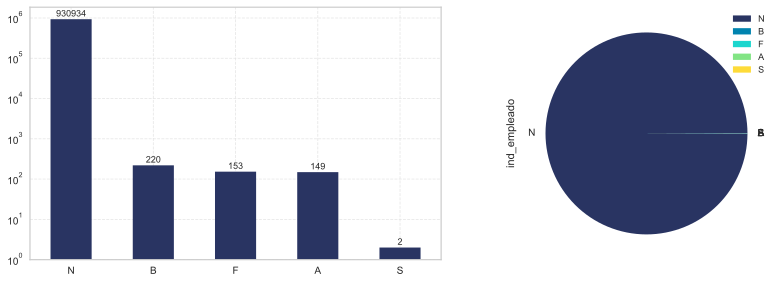

In [33]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

bars = df.ind_empleado.value_counts().plot.bar(log=True, rot=0, ax=ax1)
ax1.bar_label(bars.containers[0], padding=1)

df.ind_empleado.value_counts().plot.pie(ax=ax2)
ax2.legend()

Plot.show()

**Considerações**

- Maior concentração dos clientes são de não-funcionários do banco. 
- Podemos assumir nesta análise a segmentação apenas dos não-funcionários. Posteriormente, poderia ser realizada uma nova análise e segmentação apenas dos clientes funcionários, pois estes normalmente possuem algumas vantagens com relação aos produtos do banco.

### `pais_residencia`

In [34]:
df.pais_residencia.value_counts()

ES    927461
FR       312
AR       289
GB       283
DE       280
       ...  
BZ         1
CD         1
ZW         1
GM         1
DJ         1
Name: pais_residencia, Length: 118, dtype: int64

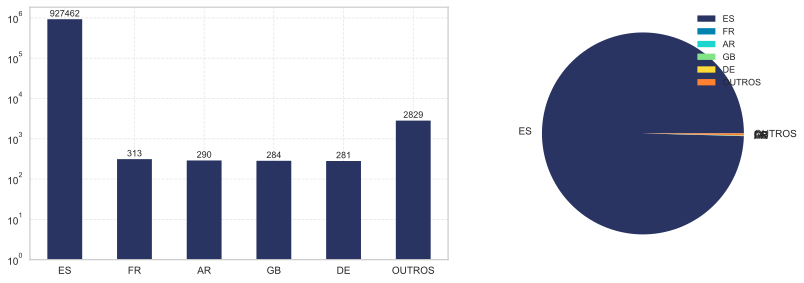

In [35]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

# Cria uma nova categoria
df1 = df.pais_residencia.value_counts()[:5]
df2 = pd.Series({'OUTROS': df.pais_residencia.value_counts()[5:].sum()})
df3 = pd.concat([df1, df2])

bars = df3.plot.bar(log=True, rot=0, ax=ax1)
ax1.bar_label(bars.containers[0], padding=1)

df3.plot.pie(ax=ax2)
ax2.legend()

Plot.show()

**Considerações**

- Maior concentração de clientes na Espanha.
- Como alguns clientes de outros países possuem dados nulos, neste estudo serão considerados apenas os clientes que residem na Espanha.

### `sexo`

In [36]:
df.sexo.value_counts()

V    505582
H    425866
Name: sexo, dtype: int64

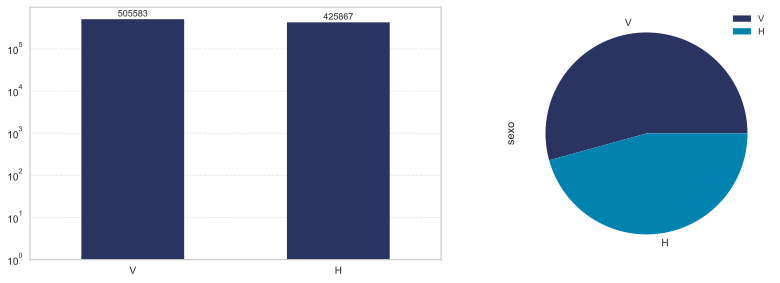

In [37]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

bars = df.sexo.value_counts().plot.bar(log=True, rot=0, ax=ax1)
ax1.bar_label(bars.containers[0], padding=1)

df.sexo.value_counts().plot.pie(ax=ax2)
ax2.legend()

Plot.show()

**Considerações**

- Classe bem equilibrada e possui um bom potencial de discriminação entre os clientes. 
- Possui valores nulos.

### `indrel_1mes`

In [38]:
df.indrel_1mes.value_counts()

1.0    612214
1      314700
3.0       189
3         116
P          77
2.0        62
2          60
4.0        17
4           8
Name: indrel_1mes, dtype: int64

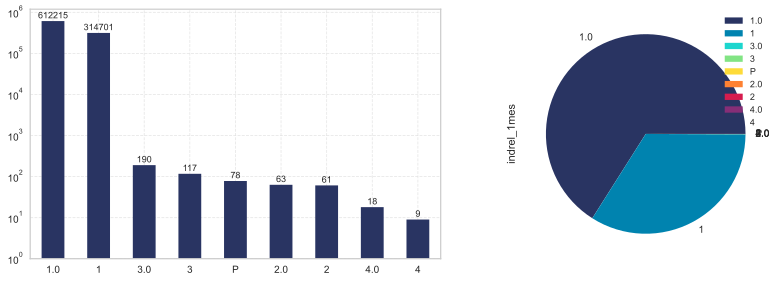

In [39]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

bars = df.indrel_1mes.value_counts().plot.bar(log=True, rot=0, ax=ax1)
ax1.bar_label(bars.containers[0], padding=1)

df.indrel_1mes.value_counts().plot.pie(ax=ax2)
ax2.legend()

Plot.show()

**Considerações**

- Maior concentração de clientes primários 1.
- Valores misturados entre inteiro e real, precisa ser normalizado.
- Para simplificar o problema, serão analisados apenas os perfis dos clientes primários.

`tiprel_1mes`

In [40]:
df.tiprel_1mes.value_counts()

I    534429
A    392607
P       330
R        77
Name: tiprel_1mes, dtype: int64

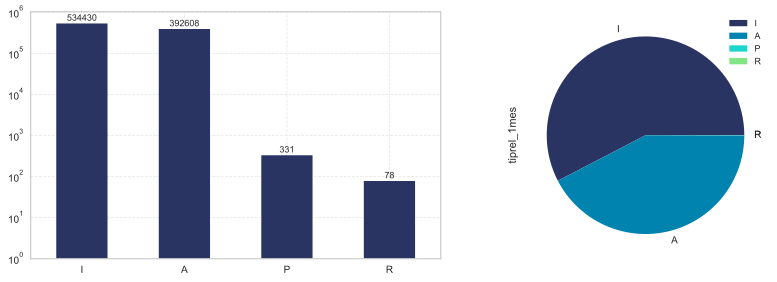

In [41]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

bars = df.tiprel_1mes.value_counts().plot.bar(log=True, rot=0, ax=ax1)
ax1.bar_label(bars.containers[0], padding=1)

df.tiprel_1mes.value_counts().plot.pie(ax=ax2)
ax2.legend()

Plot.show()

**Considerações**

- Considerar apenas os clientes ativos e inativos.

### `indresi`

In [42]:
df.indresi.value_counts()

S    927461
N      3992
Name: indresi, dtype: int64

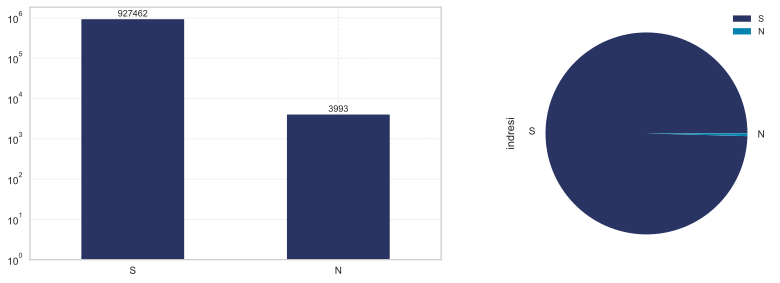

In [43]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

bars = df.indresi.value_counts().plot.bar(log=True, rot=0, ax=ax1)
ax1.bar_label(bars.containers[0], padding=1)

df.indresi.value_counts().plot.pie(ax=ax2)
ax2.legend()

Plot.show()

**Considerações**

- Maior concentração clientes que residem no mesmo país do banco.
- Selecionar apenas estes clientes para a análise.

### `indext`

In [44]:
df.indext.value_counts()

N    885213
S     46240
Name: indext, dtype: int64

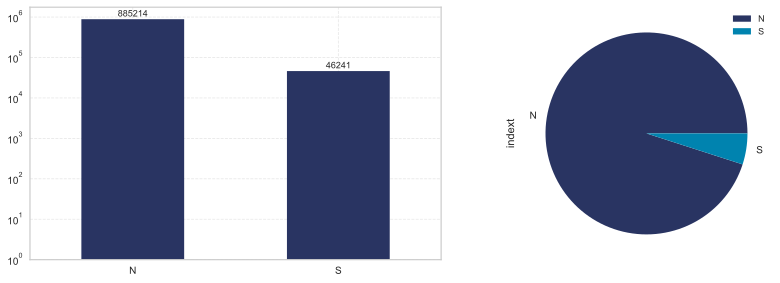

In [45]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

bars = df.indext.value_counts().plot.bar(log=True, rot=0, ax=ax1)
ax1.bar_label(bars.containers[0], padding=1)

df.indext.value_counts().plot.pie(ax=ax2)
ax2.legend()

Plot.show()

**Considerações**

- Maior concentração de clientes que não nasceram em outro país.
- Por ser um atributo categórico e desbalanceado, será ignorado.

### `canal_entrada`

In [46]:
df.canal_entrada.value_counts()

KHE    251804
KAT    206088
KFC    200892
KHQ     75073
KHM     31120
        ...  
KDL         1
KDI         1
KDB         1
025         1
KGN         1
Name: canal_entrada, Length: 162, dtype: int64

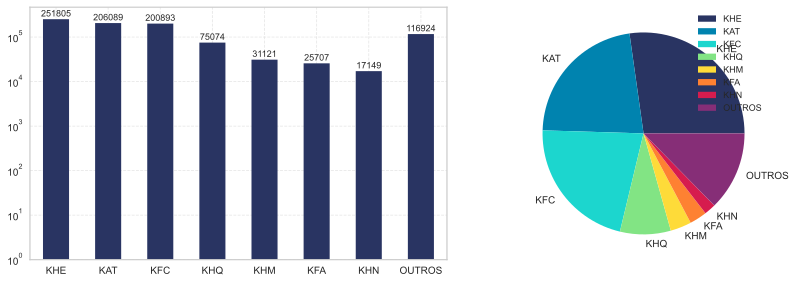

In [47]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

# Cria uma nova categoria
df1 = df.canal_entrada.value_counts()[:7]
df2 = pd.Series({'OUTROS': df.canal_entrada.value_counts()[7:].sum()})
df3 = pd.concat([df1, df2])

bars = df3.plot.bar(log=True, rot=0, ax=ax1)
ax1.bar_label(bars.containers[0], padding=1)

df3.plot.pie(ax=ax2)
ax2.legend()

Plot.show()

**Considerações**

- KHE, KFC, KHE tem a maior frequência no conjunto.
- Outras classes tem menor frequência, podem ser agrupadas.

### `indfall`

In [48]:
df.indfall.value_counts()

N    929087
S      2366
Name: indfall, dtype: int64

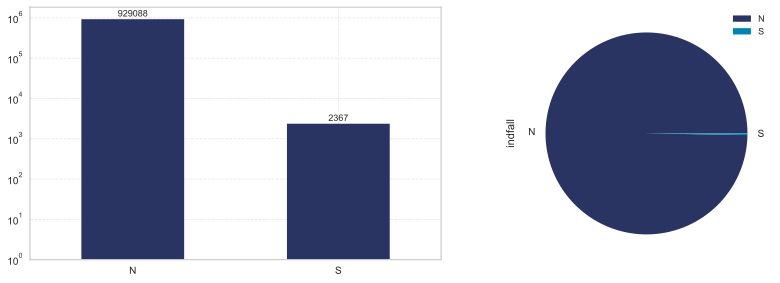

In [49]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

bars = df.indfall.value_counts().plot.bar(log=True, rot=0, ax=ax1)
ax1.bar_label(bars.containers[0], padding=1)

df.indfall.value_counts().plot.pie(ax=ax2)
ax2.legend()

Plot.show()

**Considerações**

- Remover os clientes com status S. 

### `nomprov`

In [50]:
df.nomprov.value_counts()

MADRID       298841
BARCELONA     88754
VALENCIA      48103
SEVILLA       40581
CORUÑA, A     28771
              ...  
ALAVA          2597
TERUEL         1538
SORIA          1261
MELILLA         641
CEUTA           513
Name: nomprov, Length: 52, dtype: int64

In [51]:
df.query('pais_residencia != "ES" and nomprov.notna()')[['nomprov', 'pais_residencia']]

,nomprov,pais_residencia
251031,MADRID,DE
256521,MADRID,IT
258803,MADRID,BO
351268,"PALMAS, LAS",PY
356733,GUADALAJARA,PY


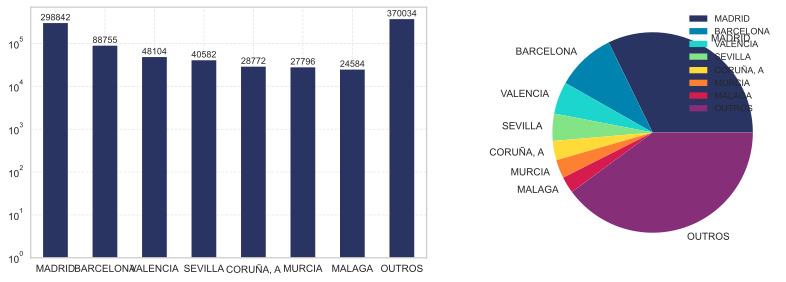

In [52]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

# Cria uma nova categoria
df1 = df.nomprov.value_counts()[:7]
df2 = pd.Series({'OUTROS': df.nomprov.value_counts()[7:].sum()})
df3 = pd.concat([df1, df2])

bars = df3.plot.bar(log=True, rot=0, ax=ax1)
ax1.bar_label(bars.containers[0], padding=1)

df3.plot.pie(ax=ax2)
ax2.legend()

Plot.show()

**Considerações**

- Existem 4 províncias com classificação errada.
- As cidades são atributos categóricos e não possuem relação de ordem. O ideal é trabalhar como coordenadas geográficas, assim é possível identificar se pessoas próximas a uma região possuem o mesmo perfil.

### `segmento`

In [53]:
df.segmento.value_counts()

02 - PARTICULARES     542596
03 - UNIVERSITARIO    346417
01 - TOP               35415
Name: segmento, dtype: int64

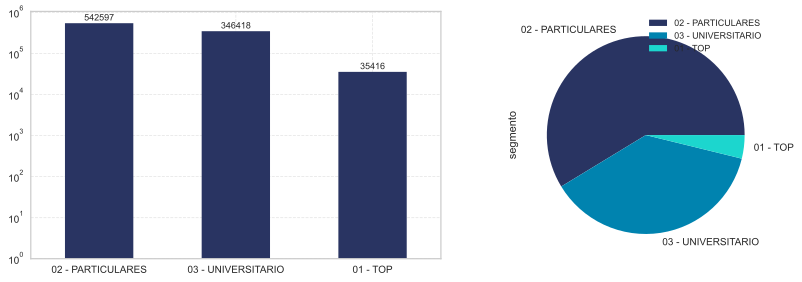

In [54]:
fig, (ax1, ax2) = Plot.subplots(nrows=1, ncols=2)

bars = df.segmento.value_counts().plot.bar(log=True, rot=0, ax=ax1)
ax1.bar_label(bars.containers[0], padding=1)

df.segmento.value_counts().plot.pie(ax=ax2)
ax2.legend()

Plot.show()

**Considerações**

- Existem valores nulos.

## Análise - atributos booleanos

In [55]:
# Verifica o domínio de todos os atributos do conjunto de dados
DataAnalysis.print_summary(df, 'bool')

                                                    Tipo: bool                                                     
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Tipo   ┃ Atributo           ┃ Domínio                                                ┃ Únicos ┃ Nulos  ┃ Nulos% ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ bool   │ ind_nuevo          │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ conyuemp           │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ tipodom            │ [ True]                                                │ 1      │ 0      │ 0.00%  │
│ bool   │ ind_actividad_cli… │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_ahor_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_aval_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_cco_fin_ult1   │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_cder_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_cno_fin_ult1   │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_ctju_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_ctma_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_ctop_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_ctpp_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_deco_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_deme_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_dela_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_ecue_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_fond_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_hip_fin_ult1   │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_plan_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_pres_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_reca_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_tjcr_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_valo_fin_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_viv_fin_ult1   │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_nomina_ult1    │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_nom_pens_ult1  │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
│ bool   │ ind_recibo_ult1    │ [False  True]                                          │ 2      │ 0      │ 0.00%  │
└────────┴────────────────────┴────────────────────────────────────────────────────────┴────────┴────────┴────────┘

In [56]:
campos_booleanos = ['ind_nuevo', 'conyuemp', 'tipodom', 'ind_actividad_cliente', 'ind_ahor_fin_ult1',
                    'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1',
                    'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
                    'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1',
                    'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1',
                    'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
                    'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1',]
len(campos_booleanos)

28

In [57]:
table = Table(show_header=True, header_style="bold", title=f'Atributos booleanos') 
table.add_column("Atributo", style="green", width=24)
table.add_column("True",  style='blue', width=24)
table.add_column("False",  style='red', width=24)

resumo = []
for i in campos_booleanos:
    ntrue = len(df[i][df[i] == True])
    nfalse = len(df[i][df[i] == False])
    total = len(df[i])
    resumo.append((i, ntrue, nfalse))
                 
# Desenha a tabela
for i, ntrue, nfalse in sorted(resumo, key=lambda k: k[1], reverse=True):
    table.add_row(i, f'{ntrue / total * 100:.2f}%', f'{nfalse / total * 100:.2f}%')

console.print(table)

                               Atributos booleanos                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Atributo                 ┃ True                     ┃ False                    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tipodom                  │ 100.00%                  │ 0.00%                    │
│ ind_cco_fin_ult1         │ 60.29%                   │ 39.71%                   │
│ ind_actividad_cliente    │ 42.48%                   │ 57.52%                   │
│ ind_recibo_ult1          │ 12.14%                   │ 87.86%                   │
│ ind_ctop_fin_ult1        │ 10.80%                   │ 89.20%                   │
│ ind_ecue_fin_ult1        │ 8.14%                    │ 91.86%                   │
│ ind_cno_fin_ult1         │ 7.84%                    │ 92.16%                   │
│ ind_nom_pens_ult1        │ 5.67%                    │ 94.33%                   │
│ ind_nomina_ult1          │ 5.19%                    │ 94.81%                   │
│ ind_reca_fin_ult1        │ 4.89%                    │ 95.11%                   │
│ ind_tjcr_fin_ult1        │ 3.74%                    │ 96.26%                   │
│ ind_nuevo                │ 3.69%                    │ 96.31%                   │
│ ind_ctpp_fin_ult1        │ 3.57%                    │ 96.43%                   │
│ ind_dela_fin_ult1        │ 3.35%                    │ 96.65%                   │
│ ind_valo_fin_ult1        │ 2.30%                    │ 97.70%                   │
│ ind_fond_fin_ult1        │ 1.58%                    │ 98.42%                   │
│ ind_ctma_fin_ult1        │ 0.87%                    │ 99.13%                   │
│ ind_ctju_fin_ult1        │ 0.81%                    │ 99.19%                   │
│ ind_plan_fin_ult1        │ 0.79%                    │ 99.21%                   │
│ ind_hip_fin_ult1         │ 0.49%                    │ 99.51%                   │
│ ind_viv_fin_ult1         │ 0.32%                    │ 99.68%                   │
│ ind_pres_fin_ult1        │ 0.21%                    │ 99.79%                   │
│ ind_deme_fin_ult1        │ 0.11%                    │ 99.89%                   │
│ ind_deco_fin_ult1        │ 0.03%                    │ 99.97%                   │
│ ind_cder_fin_ult1        │ 0.03%                    │ 99.97%                   │
│ conyuemp                 │ 0.01%                    │ 99.99%                   │
│ ind_ahor_fin_ult1        │ 0.01%                    │ 99.99%                   │
│ ind_aval_fin_ult1        │ 0.00%                    │ 100.00%                  │
└──────────────────────────┴──────────────────────────┴──────────────────────────┘

In [58]:
# Ordena os clientes pelo número de produtos que ele possui
classes = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1',
           'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
           'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1',
           'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1',
           'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
           'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1',]
df[classes].sum(axis=1).sort_values()

0          0
412952     0
412950     0
412942     0
412940     0
          ..
259759    13
324351    13
283050    14
298717    14
334242    15
Length: 931453, dtype: int64

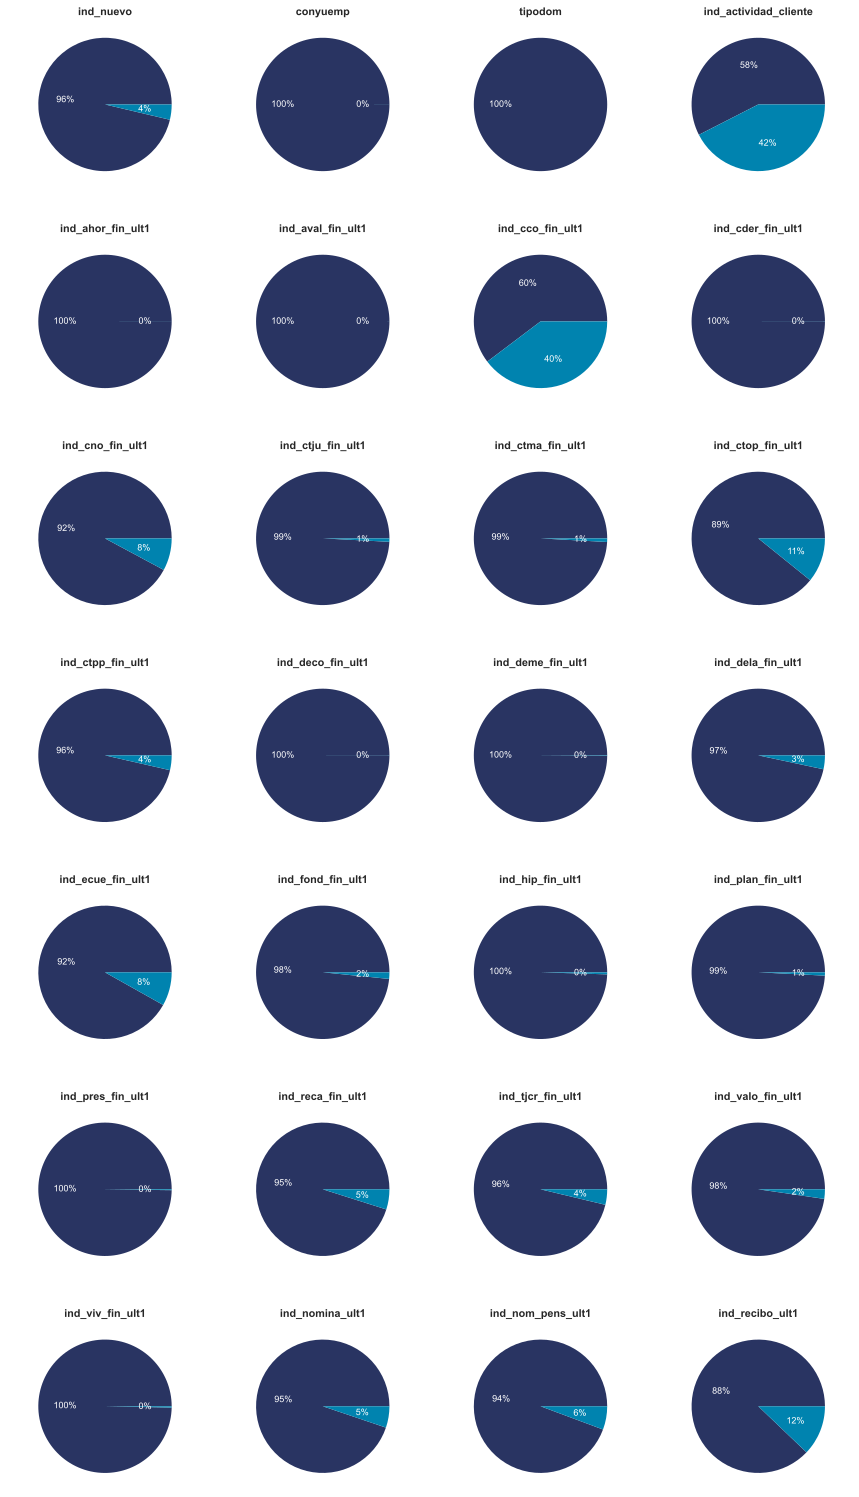

In [59]:
fig, ax = Plot.subplots(nrows=7, ncols=4)

for col, ax1 in zip(campos_booleanos, ax.flatten()):
    df[col].value_counts().plot.pie(ax=ax1, autopct='%1.0f%%', textprops={'color':"w"})
    ax1.set_title(col)
    ax1.set_ylabel('')

Plot.show()

In [60]:
classes_relevantes = ['ind_cco_fin_ult1', 'ind_recibo_ult1', 'ind_ctop_fin_ult1', 'ind_ecue_fin_ult1', 'ind_cno_fin_ult1',
                      'ind_nom_pens_ult1', 'ind_nomina_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_ctpp_fin_ult1',
                      'ind_dela_fin_ult1', 'ind_valo_fin_ult1', 'ind_fond_fin_ult1']

**Considerações**

- Atributo `tipodom` pode ser removido pois é sempre True.
- Atributo `conyuemp` e `ind_nuevo` podem ser removidos por serem binários e pouca relevância.
- Maior parte das classes estão desbalanceadas, com amostragem menor que 1%.
- Classes mais relevantes:
    - ind_cco_fin_ult1: Conta Corrente
    - ind_recibo_ult1: Débito Direto
    - nd_ctop_fin_ult1: Conta Particular
    - ind_ecue_fin_ult1: e-account
    - ind_cno_fin_ult1: Conta Salário
    - ind_nom_pens_ult1: Pensão
    - ind_nomina_ult1: Folha de pagamento
    - ind_reca_fin_ult1: Impostos
    - ind_tjcr_fin_ult1: Cartão de crédito
    - ind_ctpp_fin_ult1: Conta Particular Plus
    - ind_dela_fin_ult1: Déposito Longo-Prazo
    - ind_valo_fin_ult1: Títulos
    - ind_fond_fin_ult1: Fundos                
    

## Resumo

**Atributos numéricos**

- [x] `indrel`: remover
- [x] `age`: remover outliers < 18 e > 90
- [x] `ncodpers`: definir como índice do DataFrame
- [x] `antiguedad`: remover os registros com valor -999999
- [x] `cod_prov`: remover este campo
- [x] `renta`: 
    - remover dados faltantes - 25% da base

**Atributos categóricos**

- [x] `ind_empleado`: selecionar apenas os não-funcionários (N)
- [x] `pais_residencia`: selecionar apenas residentes na Espanha (ES)
- [x] `tiprel_1mes`: selecionar apenas clientes ativos e inativos (A, I)
- [x] `indrel_1mes`: 
    - normalizar valores para P, 1, 2, 3, 4
    - selecionar apenas clientes primários (1)
- [x] `indresi`: selecionar apenas residentes no país do banco (S)
- [x] `indext`: remover
- [x] `canal_entrada`: agrupar os canais com menor frequência
- [x] `indfall`: selecionar apenas os clientes vivos (N)
- [x] `nomprov`: 
    - corrigir cidades com classificação errada
    - TODO: converter para coordenadas geográficas
- [x] `conyuemp`: remover
- [x] Remover os exemplos com valores nulos
- [x] Converter atributos categóricos para inteiros: `ind_empleado`, `pais_residencia`, `sexo`, `indrel_1mes`, `tiprel_1mes`, `indresi`, `indext`, `canal_entrada`, `indfall`, `nomprov`, `segmento`

**Atributos booleanos**

- [x] `tipodom`: remover 
- [x] criar novo atributo com base no número de produtos que um cliente possui

# 🧹 Limpeza dos dados

In [61]:
# Salva a referência do DataFrame original
df0 = df.copy()

## Atualização do índice

In [62]:
# Atualiza o índice do DataFrame
df1 = df0.set_index('ncodpers')

## Atualização dos valores de renda nulos

Para os registros sem renda, vamos considerar a renda média das pessoas de cada cidade. Usaremos a mediana para evitar a distorção das pessoas super ricas que existem na base de dados. 

In [63]:
renda_por_cidade = df1[['renta', 'nomprov']].groupby('nomprov').median().to_dict()['renta']

for cidade, renda in renda_por_cidade.items():
    df1.loc[(df1['renta'].isna()) & (df1['nomprov'] == cidade), 'renta'] = renda
    
df1[df1['renta'].isna()].shape

(3952, 44)

Cerca de 3952 clientes não possuem nem cidade, nem renda. Por ser um número pequeno, estes registros podem ser descartados.

## Remoção dos registros nulos

In [64]:
# Remoção dos registros nulos dos atributos categóricos
df2 = df1.dropna()
df2.shape

(920396, 44)

## Conversão de tipos

In [65]:
# Corrige os parâmetros do indrel_1mes
def corrigir_indrel_1mes(x):
    if x in ('1', '1.0'):
        return '1'
    elif x in ('2', '2.0'):
        return '2'
    elif x in ('3', '3.0'):
        return '3'
    elif x in ('4', '4.0'):
        return '4'
    return x

dfx = df2.copy()
dfx['indrel_1mes'] = dfx['indrel_1mes'].map(corrigir_indrel_1mes)
dfx = dfx[dfx.indrel_1mes == '1']

df3 = dfx
df3.indrel_1mes.value_counts()

1    920392
Name: indrel_1mes, dtype: int64

In [66]:
# Mescla os canais com pouca representatividade
dfx = df3.copy()
dfx['canal_entrada'] = dfx.canal_entrada.cat.add_categories('OUTROS')
dfx.loc[dfx['canal_entrada'].isin((dfx['canal_entrada'].value_counts()[dfx['canal_entrada'].value_counts() < 20_000]).index), 'canal_entrada'] = 'OUTROS'
dfx['canal_entrada'] = dfx.canal_entrada.cat.remove_unused_categories()

df4 = dfx
df4.canal_entrada.value_counts()

KHE       251536
KAT       204367
KFC       200278
OUTROS    132983
KHQ        75073
KHM        31080
KFA        25075
Name: canal_entrada, dtype: int64

In [67]:
# Corrige as cidades erradas
dfx = df4.copy()
dfx.loc[dfx.query('pais_residencia != "ES" and nomprov.notna()').index, 'pais_residencia'] = 'ES'

df5 = dfx
df5.query('pais_residencia != "ES" and nomprov.notna()')[['nomprov', 'pais_residencia']]

,nomprov,pais_residencia
ncodpers,,


## Remoção dos outliers

In [68]:
# Remove as idades que podem ser outliers
df6 = df5.query('age >= 18 and age <= 90')
df6.shape

(906284, 44)

In [69]:
# Remove os registros inválidos
df7 = df6.query('antiguedad >= 0')
df7.shape

(906281, 44)

In [70]:
# Seleciona apenas não funcionários
df8 = df7.query('ind_empleado == "N"')
df8.shape

(905765, 44)

In [71]:
df9 = df8.query('pais_residencia == "ES"')
df9.shape

(905765, 44)

In [72]:
df10 = df9.query('indresi == "S"')
df10.shape

(905761, 44)

In [73]:
df11 = df10.query('indfall == "N"')
df11.shape

(904157, 44)

In [74]:
df12 = df11.query('tiprel_1mes in ("A", "I")')
df12.shape

(904157, 44)

## Remoção dos atributos

In [75]:
# Remoção dos atributos com pouca relevância
excluidos = ['tipodom', 'cod_prov', 'indrel', 'indext', 'indrel_1mes', 'ind_nuevo', 'tiprel_1mes', 
             'ind_empleado', 'pais_residencia', 'indresi', 'indfall' , 'conyuemp',
             'ind_ctma_fin_ult1', 'ind_ctju_fin_ult1', 'ind_plan_fin_ult1', 
             'ind_hip_fin_ult1', 'ind_viv_fin_ult1', 'ind_pres_fin_ult1', 'ind_deme_fin_ult1',
             'ind_deco_fin_ult1', 'ind_cder_fin_ult1', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1']
            
df13 = df12.drop(columns=excluidos)
df13.head()

,sexo,age,antiguedad,canal_entrada,nomprov,ind_actividad_cliente,renta,segmento,ind_cco_fin_ult1,ind_cno_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
ncodpers,,,,,,,,,,,,,,,,,,,,,
657640,H,68,114,OUTROS,MADRID,False,147347.970,02 - PARTICULARES,False,False,False,False,False,False,False,False,False,False,False,False,False
657788,H,42,114,OUTROS,MADRID,True,132559.350,02 - PARTICULARES,True,False,False,False,False,False,False,False,False,False,False,False,False
657795,V,44,114,OUTROS,"RIOJA, LA",True,81399.570,02 - PARTICULARES,True,False,False,False,False,False,False,False,False,False,False,False,False
657790,V,42,114,OUTROS,BIZKAIA,True,97637.505,02 - PARTICULARES,False,True,False,False,False,True,False,False,True,False,True,True,True
657794,H,49,114,KAT,BARCELONA,True,102189.000,01 - TOP,True,False,False,False,True,False,False,False,False,False,False,False,False


## Criação dos atributos

In [76]:
df14 = df13.copy()
df14['num_produtos'] = df14[classes_relevantes].sum(axis=1)
df14.head()

,sexo,age,antiguedad,canal_entrada,nomprov,ind_actividad_cliente,renta,segmento,ind_cco_fin_ult1,ind_cno_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,num_produtos
ncodpers,,,,,,,,,,,,,,,,,,,,,,
657640,H,68,114,OUTROS,MADRID,False,147347.970,02 - PARTICULARES,False,False,False,False,False,False,False,False,False,False,False,False,False,0
657788,H,42,114,OUTROS,MADRID,True,132559.350,02 - PARTICULARES,True,False,False,False,False,False,False,False,False,False,False,False,False,1
657795,V,44,114,OUTROS,"RIOJA, LA",True,81399.570,02 - PARTICULARES,True,False,False,False,False,False,False,False,False,False,False,False,False,1
657790,V,42,114,OUTROS,BIZKAIA,True,97637.505,02 - PARTICULARES,False,True,False,False,False,True,False,False,True,False,True,True,True,6
657794,H,49,114,KAT,BARCELONA,True,102189.000,01 - TOP,True,False,False,False,True,False,False,False,False,False,False,False,False,2


## Converte valores categóricos

In [77]:
# Converte as classes booleanas para 0 .. 1
dfx = df14.copy()

classes_bool = classes_relevantes + ['ind_actividad_cliente']
for classe in classes_bool:
    dfx[classe].replace({True: 1, False: 0}, inplace=True)
    
df15 = dfx
df15

,sexo,age,antiguedad,canal_entrada,nomprov,ind_actividad_cliente,renta,segmento,ind_cco_fin_ult1,ind_cno_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,num_produtos
ncodpers,,,,,,,,,,,,,,,,,,,,,,
657640,H,68,114,OUTROS,MADRID,0,147347.970,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0
657788,H,42,114,OUTROS,MADRID,1,132559.350,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,1
657795,V,44,114,OUTROS,"RIOJA, LA",1,81399.570,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,1
657790,V,42,114,OUTROS,BIZKAIA,1,97637.505,02 - PARTICULARES,0,1,0,0,0,1,0,0,1,0,1,1,1,6
657794,H,49,114,KAT,BARCELONA,1,102189.000,01 - TOP,1,0,0,0,1,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166766,V,25,33,KHE,ZARAGOZA,0,50945.250,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1166765,V,22,33,KHE,ZARAGOZA,0,43912.170,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1166764,V,23,33,KHE,"RIOJA, LA",0,23334.990,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [78]:
df16 = pd.get_dummies(df15, columns=['sexo', 'canal_entrada', 'nomprov', 'ind_actividad_cliente', 'segmento'])
df16.head()

,age,antiguedad,renta,ind_cco_fin_ult1,ind_cno_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,num_produtos,sexo_H,sexo_V,canal_entrada_KAT,canal_entrada_KFA,canal_entrada_KFC,canal_entrada_KHE,canal_entrada_KHM,canal_entrada_KHQ,canal_entrada_OUTROS,nomprov_ALAVA,nomprov_ALBACETE,nomprov_ALICANTE,nomprov_ALMERIA,nomprov_ASTURIAS,nomprov_AVILA,nomprov_BADAJOZ,"nomprov_BALEARS, ILLES",nomprov_BARCELONA,nomprov_BIZKAIA,nomprov_BURGOS,nomprov_CACERES,nomprov_CADIZ,nomprov_CANTABRIA,nomprov_CASTELLON,nomprov_CEUTA,nomprov_CIUDAD REAL,nomprov_CORDOBA,"nomprov_CORUÑA, A",nomprov_CUENCA,nomprov_GIPUZKOA,nomprov_GIRONA,nomprov_GRANADA,nomprov_GUADALAJARA,nomprov_HUELVA,nomprov_HUESCA,nomprov_JAEN,nomprov_LEON,nomprov_LERIDA,nomprov_LUGO,nomprov_MADRID,nomprov_MALAGA,nomprov_MELILLA,nomprov_MURCIA,nomprov_NAVARRA,nomprov_OURENSE,nomprov_PALENCIA,"nomprov_PALMAS, LAS",nomprov_PONTEVEDRA,"nomprov_RIOJA, LA",nomprov_SALAMANCA,nomprov_SANTA CRUZ DE TENERIFE,nomprov_SEGOVIA,nomprov_SEVILLA,nomprov_SORIA,nomprov_TARRAGONA,nomprov_TERUEL,nomprov_TOLEDO,nomprov_VALENCIA,nomprov_VALLADOLID,nomprov_ZAMORA,nomprov_ZARAGOZA,ind_actividad_cliente_0,ind_actividad_cliente_1,segmento_01 - TOP,segmento_02 - PARTICULARES,segmento_03 - UNIVERSITARIO
ncodpers,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657640,68,114,147347.970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
657788,42,114,132559.350,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
657795,44,114,81399.570,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
657790,42,114,97637.505,0,1,0,0,0,1,0,0,1,0,1,1,1,6,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
657794,49,114,102189.000,1,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


## Converte as escalas dos valores numéricos

In [79]:
atributos = ['age', 'antiguedad', 'renta', 'num_produtos']

scaler = MinMaxScaler()

dfx = df16.copy()
dfx[atributos] = scaler.fit_transform(dfx[atributos].values)

df17 = dfx
df17.head()

,age,antiguedad,renta,ind_cco_fin_ult1,ind_cno_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,num_produtos,sexo_H,sexo_V,canal_entrada_KAT,canal_entrada_KFA,canal_entrada_KFC,canal_entrada_KHE,canal_entrada_KHM,canal_entrada_KHQ,canal_entrada_OUTROS,nomprov_ALAVA,nomprov_ALBACETE,nomprov_ALICANTE,nomprov_ALMERIA,nomprov_ASTURIAS,nomprov_AVILA,nomprov_BADAJOZ,"nomprov_BALEARS, ILLES",nomprov_BARCELONA,nomprov_BIZKAIA,nomprov_BURGOS,nomprov_CACERES,nomprov_CADIZ,nomprov_CANTABRIA,nomprov_CASTELLON,nomprov_CEUTA,nomprov_CIUDAD REAL,nomprov_CORDOBA,"nomprov_CORUÑA, A",nomprov_CUENCA,nomprov_GIPUZKOA,nomprov_GIRONA,nomprov_GRANADA,nomprov_GUADALAJARA,nomprov_HUELVA,nomprov_HUESCA,nomprov_JAEN,nomprov_LEON,nomprov_LERIDA,nomprov_LUGO,nomprov_MADRID,nomprov_MALAGA,nomprov_MELILLA,nomprov_MURCIA,nomprov_NAVARRA,nomprov_OURENSE,nomprov_PALENCIA,"nomprov_PALMAS, LAS",nomprov_PONTEVEDRA,"nomprov_RIOJA, LA",nomprov_SALAMANCA,nomprov_SANTA CRUZ DE TENERIFE,nomprov_SEGOVIA,nomprov_SEVILLA,nomprov_SORIA,nomprov_TARRAGONA,nomprov_TERUEL,nomprov_TOLEDO,nomprov_VALENCIA,nomprov_VALLADOLID,nomprov_ZAMORA,nomprov_ZARAGOZA,ind_actividad_cliente_0,ind_actividad_cliente_1,segmento_01 - TOP,segmento_02 - PARTICULARES,segmento_03 - UNIVERSITARIO
ncodpers,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657640,0.694444,0.445312,0.005058,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
657788,0.333333,0.445312,0.004546,1,0,0,0,0,0,0,0,0,0,0,0,0,0.076923,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
657795,0.361111,0.445312,0.002776,1,0,0,0,0,0,0,0,0,0,0,0,0,0.076923,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
657790,0.333333,0.445312,0.003338,0,1,0,0,0,1,0,0,1,0,1,1,1,0.461538,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
657794,0.430556,0.445312,0.003495,1,0,0,0,1,0,0,0,0,0,0,0,0,0.153846,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [80]:
df17.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 904157 entries, 657640 to 1166789
Data columns (total 83 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   age                             904157 non-null  float64
 1   antiguedad                      904157 non-null  float64
 2   renta                           904157 non-null  float64
 3   ind_cco_fin_ult1                904157 non-null  int64  
 4   ind_cno_fin_ult1                904157 non-null  int64  
 5   ind_ctop_fin_ult1               904157 non-null  int64  
 6   ind_ctpp_fin_ult1               904157 non-null  int64  
 7   ind_dela_fin_ult1               904157 non-null  int64  
 8   ind_ecue_fin_ult1               904157 non-null  int64  
 9   ind_fond_fin_ult1               904157 non-null  int64  
 10  ind_reca_fin_ult1               904157 non-null  int64  
 11  ind_tjcr_fin_ult1               904157 non-null  int64  
 12  ind_valo_f

In [81]:
DataAnalysis.print_summary(df17)

                                                     Tipo: int                                                     
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Tipo   ┃ Atributo           ┃ Domínio                                                ┃ Únicos ┃ Nulos  ┃ Nulos% ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ uint8  │ sexo_H             │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ sexo_V             │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ canal_entrada_KAT  │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ canal_entrada_KFA  │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ canal_entrada_KFC  │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ canal_entrada_KHE  │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ canal_entrada_KHM  │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ canal_entrada_KHQ  │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ canal_entrada_OUT… │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_ALAVA      │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_ALBACETE   │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_ALICANTE   │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_ALMERIA    │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_ASTURIAS   │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_AVILA      │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_BADAJOZ    │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_BALEARS,   │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│        │ ILLES              │                                                        │        │        │        │
│ uint8  │ nomprov_BARCELONA  │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_BIZKAIA    │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_BURGOS     │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_CACERES    │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_CADIZ      │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_CANTABRIA  │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_CASTELLON  │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_CEUTA      │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_CIUDAD     │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│        │ REAL               │                                                        │        │        │        │
│ uint8  │ nomprov_CORDOBA    │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_CORUÑA, A  │ (0, 1)                                                 │ 2      │ 0      │ 0.00%  │
│ uint8  │ nomprov_CUENCA     │ (0, 1)                  

                                                    Tipo: float                                                    
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Tipo   ┃ Atributo           ┃ Domínio                                                ┃ Únicos ┃ Nulos  ┃ Nulos% ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ float… │ age                │ (0.0, 1.0)                                             │ 73     │ 0      │ 0.00%  │
│ float… │ antiguedad         │ (0.0, 1.0)                                             │ 257    │ 0      │ 0.00%  │
│ float… │ renta              │ (0.0, 1.0)                                             │ 510292 │ 0      │ 0.00%  │
│ float… │ num_produtos       │ (0.0, 1.0)                                             │ 14     │ 0      │ 0.00%  │
└────────┴────────────────────┴────────────────────────────────────────────────────────┴────────┴────────┴────────┘

# 🤖 Treinamento do modelo

Devido ao grande número de amostras da base, vamos selecionar apenas alguns dos atributos que representam valores contínuos e que possuam alguma relevância.

In [82]:
dff = df17
dff.head()

,age,antiguedad,renta,ind_cco_fin_ult1,ind_cno_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,num_produtos,sexo_H,sexo_V,canal_entrada_KAT,canal_entrada_KFA,canal_entrada_KFC,canal_entrada_KHE,canal_entrada_KHM,canal_entrada_KHQ,canal_entrada_OUTROS,nomprov_ALAVA,nomprov_ALBACETE,nomprov_ALICANTE,nomprov_ALMERIA,nomprov_ASTURIAS,nomprov_AVILA,nomprov_BADAJOZ,"nomprov_BALEARS, ILLES",nomprov_BARCELONA,nomprov_BIZKAIA,nomprov_BURGOS,nomprov_CACERES,nomprov_CADIZ,nomprov_CANTABRIA,nomprov_CASTELLON,nomprov_CEUTA,nomprov_CIUDAD REAL,nomprov_CORDOBA,"nomprov_CORUÑA, A",nomprov_CUENCA,nomprov_GIPUZKOA,nomprov_GIRONA,nomprov_GRANADA,nomprov_GUADALAJARA,nomprov_HUELVA,nomprov_HUESCA,nomprov_JAEN,nomprov_LEON,nomprov_LERIDA,nomprov_LUGO,nomprov_MADRID,nomprov_MALAGA,nomprov_MELILLA,nomprov_MURCIA,nomprov_NAVARRA,nomprov_OURENSE,nomprov_PALENCIA,"nomprov_PALMAS, LAS",nomprov_PONTEVEDRA,"nomprov_RIOJA, LA",nomprov_SALAMANCA,nomprov_SANTA CRUZ DE TENERIFE,nomprov_SEGOVIA,nomprov_SEVILLA,nomprov_SORIA,nomprov_TARRAGONA,nomprov_TERUEL,nomprov_TOLEDO,nomprov_VALENCIA,nomprov_VALLADOLID,nomprov_ZAMORA,nomprov_ZARAGOZA,ind_actividad_cliente_0,ind_actividad_cliente_1,segmento_01 - TOP,segmento_02 - PARTICULARES,segmento_03 - UNIVERSITARIO
ncodpers,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657640,0.694444,0.445312,0.005058,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
657788,0.333333,0.445312,0.004546,1,0,0,0,0,0,0,0,0,0,0,0,0,0.076923,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
657795,0.361111,0.445312,0.002776,1,0,0,0,0,0,0,0,0,0,0,0,0,0.076923,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
657790,0.333333,0.445312,0.003338,0,1,0,0,0,1,0,0,1,0,1,1,1,0.461538,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
657794,0.430556,0.445312,0.003495,1,0,0,0,1,0,0,0,0,0,0,0,0,0.153846,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


## KMeans

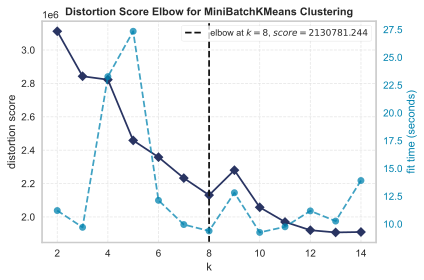

<AxesSubplot: title={'center': 'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [83]:
# Inicializa o classificador
km = MiniBatchKMeans(random_state=42, 
                     batch_size=multiprocessing.cpu_count() * 1024)

# Inicializa o visualizador do Score Elbow
visualizer = KElbowVisualizer(km, k=(2, 15))

visualizer.fit(dff)
visualizer.show()

Com base no gráfico, é possível verificar que `k = 8` apresenta o melhor resultado para número de clusters

In [84]:
# Geração do modelo - k-Means
arquivo = './modelo_kmeans-k8.pkl'

if os.path.exists(arquivo):
    # Carrega o modelo salvo localmente
    print('Carregando modelo pré-treinado...')
    km = pickle.load(open(arquivo, 'rb'))
    
else:
    # Treina o modelo
    km = MiniBatchKMeans(n_clusters=8,
                         random_state=42, 
                         batch_size=multiprocessing.cpu_count() * 1024)
    
    # Iniciao treinamento
    km.fit(dff)
    pickle.dump(km, open(arquivo, 'wb'))

Carregando modelo pré-treinado...


# DBSCAN

In [85]:
# # Geração do modelo - k-Means
# arquivo = './modelo_dbscan-db1.pkl'

# if os.path.exists(arquivo):
#     # Carrega o modelo salvo localmente
#     print('Carregando modelo pré-treinado...')
#     db1 = pickle.load(open(arquivo, 'rb'))

# else:
#     # Treina o modelo
#     db1 = DBSCAN(
#         eps=0.3,
#         min_samples=13,
#         metric='manhattan', 
#         n_jobs=-multiprocessing.cpu_count() * 2, 
#         algorithm='ball_tree', 
#         leaf_size=15, 
#     )

#     db1.fit(dff)
#     pickle.dump(db1, open(arquivo, 'wb'))

In [86]:
# # Contar número de clusters
# labels = db1.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print(f'Número estimado de clusters: {n_clusters_}')
# print(f'Número estimado de dados ruidosos: {n_noise_}')

Não foi possível concluir os testes com o DBSCAN por limitações de hardware. Em uma das execuções ele identificou 721 clusters após 12h de execução. Isso tornou inviável a análise de diferentes parâmetros para ajustes do algoritmo.

# 📊 Análise dos resultados e discussão

Para verificar o perfil de cada cluster, vamos verificar quais as classes que estão mais presentes em cada conjunto

In [87]:
df18 = df15.copy()
df18['label'] = km.labels_
df18.head()

,sexo,age,antiguedad,canal_entrada,nomprov,ind_actividad_cliente,renta,segmento,ind_cco_fin_ult1,ind_cno_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,num_produtos,label
ncodpers,,,,,,,,,,,,,,,,,,,,,,,
657640,H,68,114,OUTROS,MADRID,0,147347.970,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
657788,H,42,114,OUTROS,MADRID,1,132559.350,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4
657795,V,44,114,OUTROS,"RIOJA, LA",1,81399.570,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,1,3
657790,V,42,114,OUTROS,BIZKAIA,1,97637.505,02 - PARTICULARES,0,1,0,0,0,1,0,0,1,0,1,1,1,6,7
657794,H,49,114,KAT,BARCELONA,1,102189.000,01 - TOP,1,0,0,0,1,0,0,0,0,0,0,0,0,2,4


In [88]:
df18.groupby('label')['label'].count()

label
0    186524
1     54436
2    106525
3    147115
4     97138
5    111335
6    142187
7     58897
Name: label, dtype: int64

In [89]:
atributos = {
    'A': 'sexo',
    'B': 'canal_entrada',
    'C': 'ind_actividad_cliente',
    'D': 'segmento',
    'E': 'ind_cco_fin_ult1',
    'F': 'ind_cno_fin_ult1',
    'G': 'ind_ctop_fin_ult1',
    'H': 'ind_ctpp_fin_ult1',
    'I': 'ind_dela_fin_ult1',
    'J': 'ind_ecue_fin_ult1',
    'K': 'ind_fond_fin_ult1',
    'L': 'ind_reca_fin_ult1',
    'M': 'ind_tjcr_fin_ult1',
    'N': 'ind_valo_fin_ult1',
    'O': 'ind_nomina_ult1',
    'P': 'ind_nom_pens_ult1',
    'Q': 'ind_recibo_ult1',
}

In [92]:
dff = df18

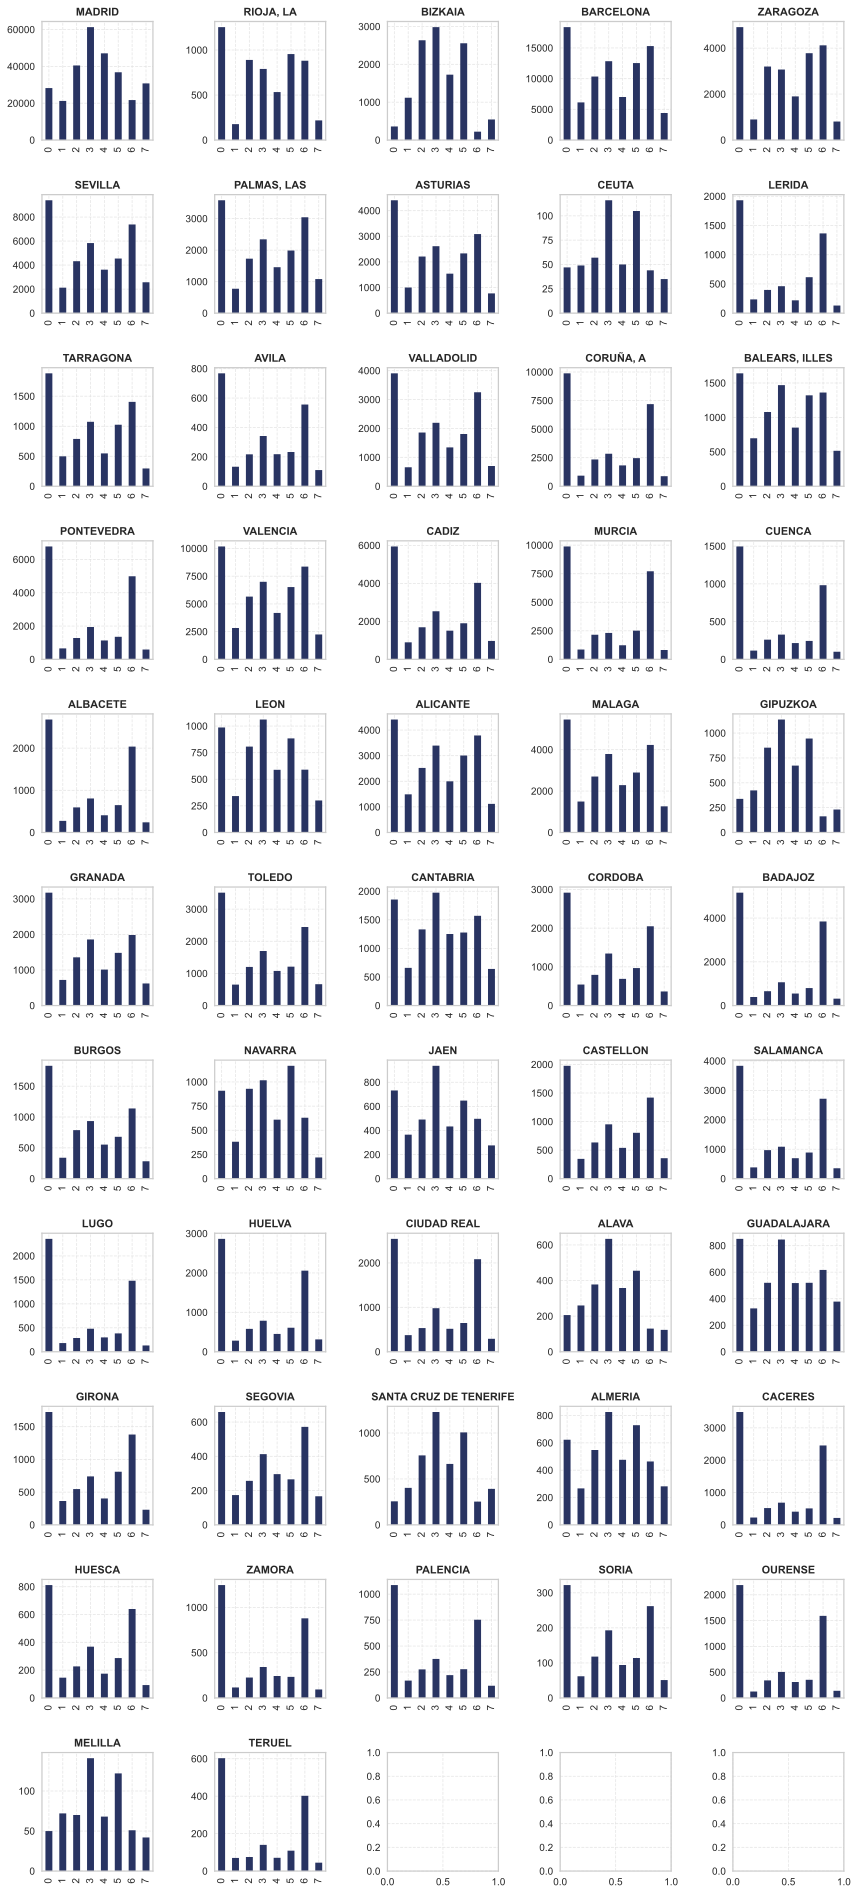

In [93]:
fig, ax = Plot.subplots(nrows=11, ncols=5)

for cidade, ax1 in zip(dff['nomprov'].unique(), ax.flatten()):
    dff.query(f'nomprov == "{cidade}"').groupby(['label'])['label'].count().plot.bar(ax=ax1, label=cidade)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.set_title(cidade)  

Plot.show()

In [94]:
cidades = []
for cidade, ax1 in zip(dff['nomprov'].unique(), ax.flatten()):
    label = str(dff.query(f'nomprov == "{cidade}"')['label'].value_counts())[0]
    cidades.append((cidade, label))
    
for cluster in range(8):
    print(cluster, ', '.join([c[0] for c in cidades if c[1] == str(cluster)]))

0 RIOJA, LA, BARCELONA, ZARAGOZA, SEVILLA, PALMAS, LAS, ASTURIAS, LERIDA, TARRAGONA, AVILA, VALLADOLID, CORUÑA, A, BALEARS, ILLES, PONTEVEDRA, VALENCIA, CADIZ, MURCIA, CUENCA, ALBACETE, ALICANTE, MALAGA, GRANADA, TOLEDO, CORDOBA, BADAJOZ, BURGOS, CASTELLON, SALAMANCA, LUGO, HUELVA, CIUDAD REAL, GUADALAJARA, GIRONA, SEGOVIA, CACERES, HUESCA, ZAMORA, PALENCIA, SORIA, OURENSE, TERUEL
1 
2 
3 MADRID, BIZKAIA, CEUTA, LEON, GIPUZKOA, CANTABRIA, JAEN, ALAVA, SANTA CRUZ DE TENERIFE, ALMERIA, MELILLA
4 
5 NAVARRA
6 
7 


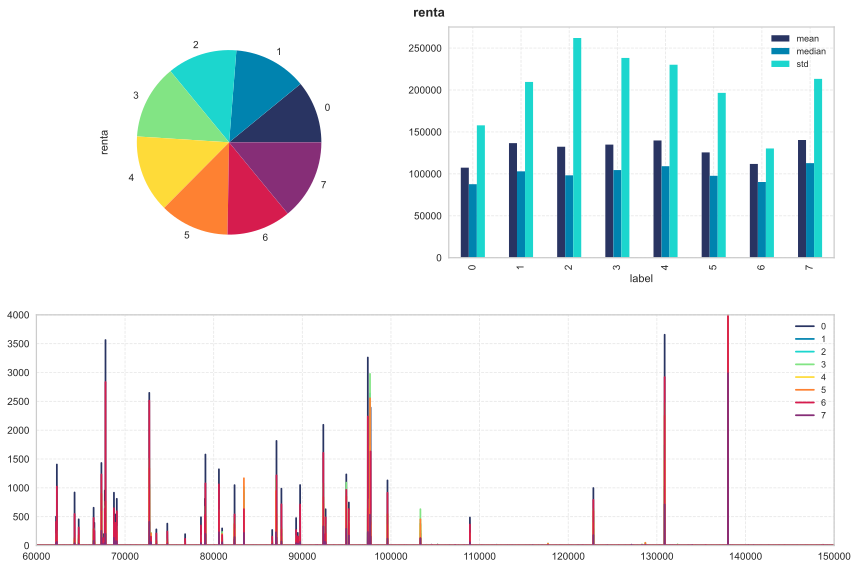

In [95]:
fig, ax = Plot.mosaic([['A', 'B'], ['C', 'C']])

dff.groupby(['label'])['renta'].median().plot.pie(ax=ax['A'])
dff.groupby(['label'])['renta'].agg(['mean', 'median', 'std']).plot.bar(ax=ax['B'])

for l in range(8):
    dff.query(f'label == {l}').groupby(['renta'])['label'].count().plot(ax=ax['C'], label=f'{l}')

ax['C'].set_xlabel('')
ax['C'].set_ylabel('')
ax['C'].set_xlim(60_000, 150_000)
ax['C'].set_ylim(0, 4000)
ax['C'].legend()    
fig.suptitle('renta')

Plot.show()

A renda não se mostrou um atributo descritivo para traçar o perfil dos clientes. Os clientes de todos os clusteres possuem renda média equivalente, como pode ser observado nos dois primeiros gráficos. O cluster 6 é o que possui menor desvio padrão da média de renda entre os clientes.

O segundo e terceiro gráficos mostram que os clientes super ricos são outliers e acabam distorcendo os grupos. Além disso, a abordagem de assumir a renda média da região como nos clientes com valores nulos de renda, gerou um viés na distribuição dos valores. A concentração de pessoas em certos valores de renda mostra esse comportamento. Deste modo, para este classificador, a renda não é um atributo relevante para identificação do perfil do cluster.

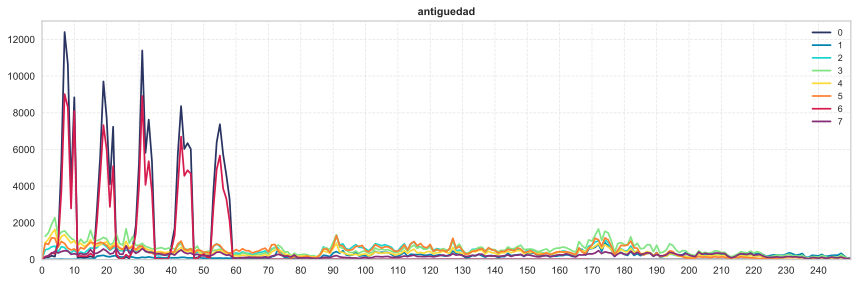

In [96]:
fig, ax = Plot.mosaic([['A', 'A']])

for l in range(8):
    dff.query(f'label == {l}').groupby(['antiguedad'])['label'].count().plot(ax=ax['A'], label=f'{l}')

ax['A'].set_title('antiguedad')
ax['A'].set_xticks(np.arange(0, 250, step=10))
ax['A'].set_xlabel('')
ax['A'].set_ylabel('')
ax['A'].set_xlim(0, 250)
ax['A'].set_ylim(0, 13_000)
ax['A'].legend()

Plot.show()

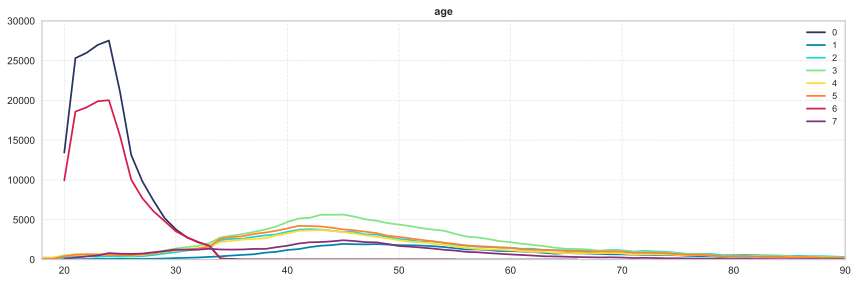

In [97]:
fig, ax = Plot.mosaic([['A', 'A']])

for l in range(8):
    dff.query(f'label == {l}').groupby(['age'])['label'].count().plot(ax=ax['A'], label=f'{l}')
    
ax['A'].set_title('age')
ax['A'].set_xlabel('')
ax['A'].set_ylabel('')
ax['A'].set_xlim(18, 90)
ax['A'].set_ylim(0, 30_000)
ax['A'].legend()

Plot.show()

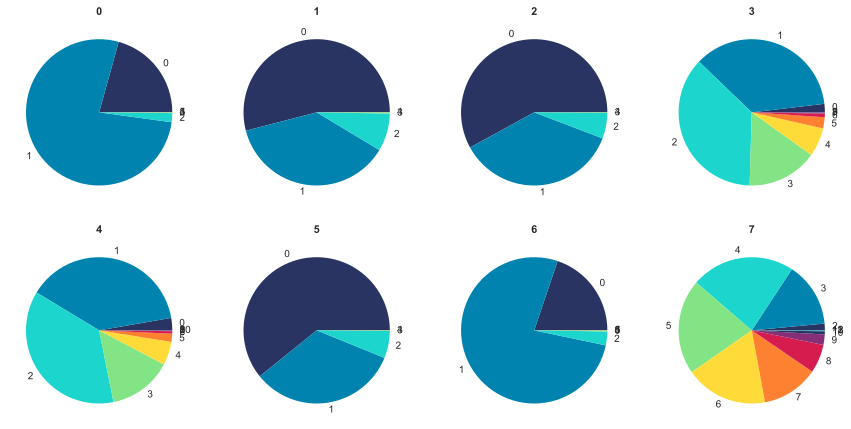

In [98]:
fig, ax = Plot.subplots(2, 4)

for l, ax1 in zip(range(8), ax.flatten()):
    dff.query(f'label == {l}').groupby('num_produtos')['label'].count().plot.pie(ax=ax1)
    ax1.set_title(str(l))
    ax1.set_xlabel('')
    ax1.set_ylabel('')

Plot.show()

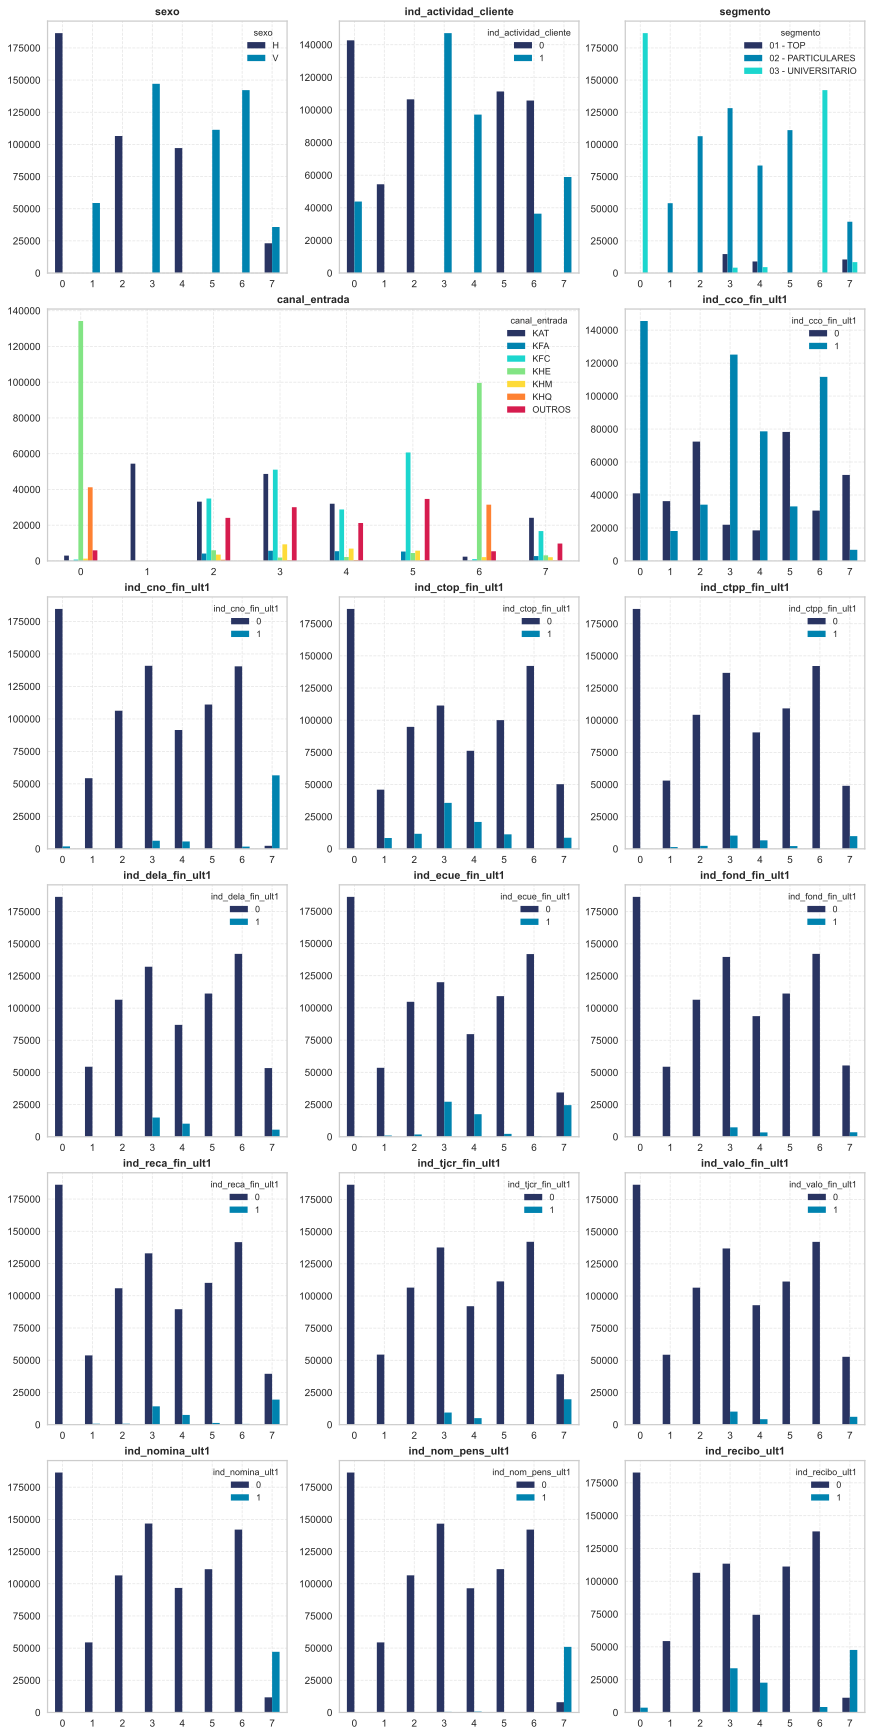

In [99]:
fig, ax = Plot.mosaic([['A', 'C', 'D'], 
                       ['B', 'B', 'E'],
                       ['F', 'G', 'H'],
                       ['I', 'J', 'K'],
                       ['L', 'M', 'N'],
                       ['O', 'P', 'Q'],                       
                      ])

for pos, atributo in atributos.items():
    dff.groupby(['label', atributo])['label'].count().unstack().plot.bar(rot=0, ax=ax[pos])
    ax[pos].set_title(atributo)
    ax[pos].set_xlabel('')
    ax[pos].set_ylabel('')

## Análise do perfil de cada cluster

### Cluster 0

- Este cluster é o mais numeroso, composto por 186.524 clientes. 
- Todas as pessoas são do sexo H na faixa dos 20 e 30 anos todos do segmento universitário.
- São clientes com contrato entre 5 e 55 meses. 
- Na sua maioria são pouco ativos com 0 ou 1 produtos do banco. 
- Os principais canais de entrada são KHE e KHQ.
- Majoritariamente possuem apenas Conta Corrente.
- São a maioria dos clientes nas seguintes cidades: RIOJA, LA, BARCELONA, ZARAGOZA, SEVILLA, PALMAS, LAS, ASTURIAS, LERIDA, TARRAGONA, AVILA, VALLADOLID, CORUÑA, A, BALEARS, ILLES, PONTEVEDRA, VALENCIA, CADIZ, MURCIA, CUENCA, ALBACETE, ALICANTE, MALAGA, GRANADA, TOLEDO, CORDOBA, BADAJOZ, BURGOS, CASTELLON, SALAMANCA, LUGO, HUELVA, CIUDAD REAL, GUADALAJARA, GIRONA, SEGOVIA, CACERES, HUESCA, ZAMORA, PALENCIA, SORIA, OURENSE, TERUEL.


### Cluster 1

- Este cluster é um dos menos numerosos, composto por 54.436 clientes. 
- Todas as pessoas são do sexo V na faixa dos 40 e 60 anos todos do segmento particular.
- No geral, possuem contratos com mais de 70 meses.
- Não são clientes ativos e possuem de 0 a 2 produtos do banco. 
- O único canal usado é o KAT.
- Poucos possuem Conta Corrente ou Conta Particular

### Cluster 2

- Todas as pessoas são do sexo H na faixa dos 30 e 70 anos todos do segmento particular.
- Não são clientes ativos e possuem de 0 a 2 produtos do banco. 
- Os principais canais de entrada são KAT, KFC e OUTROS.
- Poucos possuem Conta Corrente ou Conta Particular

### Cluster 3

- Este cluster é segundo mais numeroso, composto por 147.115 clientes.
- Todas as pessoas são do sexo V na faixa dos 40 e 60 anos do segmento particular, embora poucos clientes sejam de outros segmentos.
- São clientes ativos e possuem de 1 a 5 produtos do banco. 
- Os principais canais de entrada são KAT, KFC e OUTROS.
- Possuem grande variedade de produtos, como Conta Corrente, Conta Particular, Débito Direto, Títulos, Cartão de crédito, Impostos, e-Account, Fundos, Déposito Longo-Prazo, Conta Salário. 
- São a maioria dos clientes nas seguintes cidades: MADRID, BIZKAIA, CEUTA, LEON, GIPUZKOA, CANTABRIA, JAEN, ALAVA, SANTA CRUZ DE TENERIFE, ALMERIA, MELILLA

### Cluster 4

- Todas as pessoas são do sexo H na faixa dos 30 e 60 anos do segmento particular, embora poucos clientes sejam de outros segmentos.
- São clientes ativos e possuem de 1 a 5 produtos do banco. 
- Os principais canais de entrada são KAT, KFC e OUTROS.
- Possuem grande variedade de produtos, como Conta Corrente, Conta Particular, Débito Direto, Títulos, Cartão de crédito, Impostos, e-Account, Fundos, Déposito Longo-Prazo, Conta Salário. 
- Este cluster é bem similar ao cluster 3.

### Cluster 5

- Todas as pessoas são do sexo V na faixa dos 30 e 60 anos do segmento particular.
- Não são clientes ativos e possuem de 0 a 2 produtos do banco. 
- Os principais canais de entrada são KFC e OUTROS.
- Possuem Conta Corrente ou Conta Particular
- São a maioria dos clientes da cidade de NAVARRA
- Similar ao cluster 2

### Cluster 6

- Todas as pessoas são do sexo V na faixa dos 20 e 30 anos do segmento universitário.
- Cerca de 25% dos clientes são ativos e possuem de 0 a 1 produto do banco. 
- Os principais canais de entrada são KHE e KHQ.
- Possuem Conta Corrente ou Débito Direto.

### Cluster 7

- São clientes de ambos os sexos na faixa dos 25 e 60 anos do segmento particular, embora poucos clientes sejam de outros segmentos.
- São clientes com contrato entre 5 e 55 meses. 
- São clientes ativos e possuem de 3 a 9 produtos do banco. 
- Os principais canais de entrada são KAT, KFC e OUTROS.
- Quase a totalidade dos clientes possui Conta Salário, Pensão, Folha de pagamento, Débito direto. Os clientes também possuem outros produtos, porém, mais distribuído entre os clientes.